# Estimate spont field in water ice

_Authors: Rachel James (?), Andrew Cassidy (2), David Field (2,3)_

2. [Center for Interstellar Catalysis, Department of Physics and Astronomy, Aarhus University, DK](https://www.phys.au.dk/intercat)
3. [Department of Physics and Astronomy, Aarhus University, DK](https://www.phys.au.dk)


In [1]:
# import image module
from IPython.display import Image
from IPython.display import HTML, Markdown
import math
import numpy, pandas 
import matplotlib.pyplot as plt
import openpyxl
import xlrd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from os import listdir
from collections import defaultdict
import os
from scipy import __version__

### Abstract <a class="anchor" id="abstract"></a>
If water is polarised at all temperature of growth. Below 120 K (ish) this is asscoaited with pores, i.e., amorphous water is polarised becuase of dangling H bonds inside pores. But above 120 K, until desorption, water is also polarised. i.e., crystalline water is polarised. We aim here to see if crystalline water is spontelectric. If so, then the temperature dependence of the field induced shift in VUV peak positions, is caused by the spontectric field. That is, the magnitiude of the field that produces a shift (based on the exciton model) can be explained by fitting the field data with the spontelectric model!

### The how of if<a class="anchor" id="how?"></a>
water was deposited at a range of temperatures and VUV spectra were recorded. Rachel James fit these spectra with Gausians and provided peak positions

We propose that one of these peaks shifts with temperature because some electric field, called E$_{SP}$, acts to expand the size of the exciton related to this peak. The temperature dependence of this effect, *i.e*, the field effect on the size of the exicton is given by **Eqn. 1**

[Eqn. 1]<a class="anchor" id="equation_1"></a>
\begin{align}
\mathrm{(1)} \quad \Delta E = 2 \Delta r E_{SP}
\end{align}

If we start with some value of r and estimate a value for $\Delta E$ from the spectra, we can calculate $E_{SP}$ using the equation in figure 2

### Figure 1: Water VUV spectra at all temperatures  <a class="anchor" id="figure_1"></a>
![Water_VUV_Spectra](images/water_all_markers.png)

Rachel fit these spectra with Gaussians to extact the peak positions, indicated with dots:

![water_G_all](images/water_G_all.png)
**Figure 2**: We are interested in the last 5 points, above 125 K in this figure

This is stage 1 of 4 stages as accurately laid out in figure 3.
### Figure 3: Mind splat in the catalytic space one day  <a class="anchor" id="figure_3"></a>
![mindsplat](images/mindsplat.jpg)


**Stage 1**: Find $E_{SP}$

**Stage 2**: Convert $E_{SP}$ into $(\langle\mu_z\rangle/\mu)$ using:
[Eqn. 2]<a class="anchor" id="equation_2"></a>
\begin{align}
\mathrm{(2)} \quad E_{SP} = E_{A} \langle\mu_z\rangle/\mu
\end{align}

**Stage 3**:
Use the Spontelectric model developed by Frank to derive caluclated values of  $E_{SP}$ and $(\langle\mu_z\rangle/\mu)$; for these assumed values of "r" and $\lambda_{0}$

**Stage 4**:
take the residuals between the calculated and observed values of $E_{SP}$ and/or $(\langle\mu_z\rangle/\mu)$ and use a matrix plot to find the best [r:$\lambda_{0}$]space


### Stage 1: Calculate $E_{SP}$


In [2]:
#What molecule are we looking at?
name='water'
filename='crys_water' #these peak positins come from Rachel's Gaussian fits to water data. 
working_dir=(r'C:\Users\au302163\Fit water VUV data')

df = pd.read_csv(filename+'.txt', delim_whitespace=True, header=None)

l0=(146) # lambda_0 in nm

r_nm=(5) # in nm electron-hole radius
eps = (1.70172) #epsilon - usually take (refractive index)**2  - Kofman_2019_ApJ 
r_i=str(r_nm)
l0_j=str(l0)
ij_space=('radius: '+r_i+' nm - and l0: '+l0_j+' nm')

s_nm = 0.37 # David provided this value
print('layer spacing for '+name+' is ' + str(s_nm)+ ' nm')

mu_0_Debye = 3 # solid state dipole moment since this is known for water and avoids us recalculating it with topping equation
Omega_SI = 17.35e-30 # volume in m**3 from saga et al. (normally calculated based on polarizability, but don't do it this way for water ice).




layer spacing for water is 0.37 nm


In [3]:
#Define the relevant functions

def Langevin(x):
#
# the Langevin function for a single real argument x
# for small absolute values of x (<1.0e-6) an approximation is used that is
# correct to second order, i.e. the error term is O(eps^3)
#
    if (abs(x)>1.0e-6) :
        y=math.cosh(x)/math.sinh(x)-1/x
    else :
        y=x/3.0
    return y

def DerLangevin(x):
#
# the derivative of the Langevin function for a single real argument x
# for small absolute values of x (<1.0e-6) an approximation is used that is
# correct to second order, i.e. the error term is O(eps^2)
#
    if (abs(x)>1.0e-6) :
        auxden=1.0/math.sinh(x)
        y=-1.0*auxden*auxden+1.0/x/x
    else :
        y=1.0/3.0
    return y

def DDerLangevin(x):
#
# the second derivative of the Langevin function for a single real argument x
# for small absolute values of x (<1.0e-6) an approximation is used that is
# correct to second order, i.e. the error term is O(eps^2)
#
    if (abs(x)>1.0e-6) :
        auxden=1.0/math.sinh(x)
        y=2.0*(math.cosh(x)*auxden*auxden*auxden-1.0/x/x/x)
    else :
        y=0.0
    return y

def LangevInv(y):
#
# the inverse of the Langevin function for a single real argument y
# this uses an expression derived by Petrosyan (2017)
# 02/06/2022 (FPP): the approximation is only correct for positive values of the argument, so
#   in order to also work for negative values I have modified the function.
#
    if (abs(y)<1.0) :
        yab=abs(y)
        x=y*(3.0+yab*math.sin(7.0*yab/2.0)/5.0+yab*yab/(1-yab))
        return x
    else :
        print("LangevInv: argument out of range, stopping.")
        return

def DerLangevInv(y):
#
# the derivative of the inverse of the Langevin function for a single real argument y
# this uses an expression for the inverse of the Langevin function derived by Petrosyan (2017)
# 02/06/2022 (FPP): the approximation is only correct for positive values of the argument, so
#   in order to also work for negative values I have modified the function.
#
    if (abs(y)<1.0) :
        yab=abs(y)
        x=3.0+2.0*yab*math.sin(7.0*yab/2.0)/5.0+7.0*yab*yab*math.cos(7.0*yab/2.0)/10.0
        x+=(3.0-2.0*yab)*yab*yab/(1-yab)/(1-yab)
        return x
    else :
        print("DerLangevInv: argument out of range, stopping.")
        return
    
def NeaterOut(x,s):
#
# prepares the strings for providing nicer-looking output of parameters with uncertainties
    spon=math.floor(math.log10(abs(s)))+1
    divis=math.exp(spon*math.log(10))
    xout=x/divis
    sout=s/divis
    string='({0:.2f}$\pm${1:.2f}) $10^{2:n}$'.format(xout,sout,spon)
    return string

def ConstrLSQ(x,y,wht):
#
# Solve a linear least squares problem for 1 dependent variable y as a function of
# nvar independent variables x.
# Linear least-squares problems for more than 1 parameter require a matrix inversion
# Here for arbitrary numbers of parameters the required matrix elements are 
# calculated and the matrix is inverted, after which the parameters are obtained.
# Input: a matrix x[nvar,ndat] containing ndat measurements of nvar independent
#           variables x
#        a vector y[ndat] containing the dependent variable
#        a vector of weights [ndat] which is used to give particular measurements 
#           less weight if desired. 
# NOTE: if a constant offset is required as one of the free parameters, an x-variable 
# which is all 1's must be present in (added to) the input matrix x.
#
    if (x.shape[1] != y.shape[0]) :
        print("ConstrLSQ: unequal array lengths, stopping.")
        par=numpy.array([])
        return
    if (x.shape[1] != wht.shape[0]) :
        print("ConstrLSQ: unequal array lengths, stopping.")
        par=numpy.array([])
        return

#
# declaration of local variables
    ndat=xdat.shape[1]
    nvar=xdat.shape[0]
    whtsum=0.0
    ysum=0.0
    xsum=numpy.array([0.0]*nvar)
    xysum=numpy.array([0.0]*nvar)
    xsqsum=numpy.array([[0.0]*2,[0.0]*2])
    Ainv=numpy.array([[0.0]*2,[0.0]*2])
    par=numpy.array([0.0]*nvar)
#
# weighted sum of measurements of dependent variable 
    for i in range(0,ndat):
        ysum+=y[i]*wht[i]
#
# weighted sum of measurements of independent variables and of cross-products on independent variables
# with each other and with dependent variable.
    for k in range(0,nvar):
        for i in range(0,ndat):
            whtsum+=wht[i]
            xsum[k]+=x[k,i]*wht[i]
            xysum[k]+=x[k,i]*y[i]*wht[i]
        for l in range(0,nvar):
            for i in range(0,ndat):
                xsqsum[k,l]+=x[k,i]*x[l,i]*wht[i]
#
# start solving the set of linear equations for the linear least squares problem
    if (nvar==1) :
#
# if only one parameter to be determined
        par[0]=ysum/xsum[0]
    else:
#
# for determination of 2 parameters
        if (nvar==2) :
            Det=xsqsum[0,0]*xsqsum[1,1]-xsqsum[1,0]*xsqsum[0,1]
            if (abs(Det)>1.0e-9) :
                Ainv[0,0]=xsqsum[1,1]/Det
                Ainv[0,1]=-1.0*xsqsum[0,1]/Det
                Ainv[1,0]=-1.0*xsqsum[1,0]/Det
                Ainv[1,1]=xsqsum[0,0]/Det
                par[0]=Ainv[0,0]*xysum[0]+Ainv[0,1]*xysum[1]
                par[1]=Ainv[1,0]*xysum[0]+Ainv[1,1]*xysum[1]
            else :
                print("ConstrLSQ: singular matrix. stopping")
                par=numpy.array([])
                return
        else :
#
# the general case of 3 or more parameters to be determined.
            Ainv=numpy.linalg.inv(xsqsum)
            par=numpy.dot(Ainv,xysum)
#
    return par

# Define several conversion factors to/from atomic units
# conversion of Temp to a.u. : T [a.u.]= T [K]/factor
Ttoau=315770.0
# conversion of D to a.u. : 1 D (=Debye) = factor [a.u.]
Debye=0.393456
# Convert el. field in a.u. To V/m : E [a.u.] = E [V/m]/factor
Etoau=5.142e11
#

In [4]:
#describe the plot settings

#leg = ax.plot([r,l0,NeaterOut(EScur,SigPar[0]),NeaterOut(EAcur,SigPar[1]),NeaterOut(zetacur,SigPar[2]),format(dlsqsum)])


def FigureE(x,y,z,xmin,xmax,ymin,ymax,title):
#
# make a plot of the measured and modelled field
#
    fig, ax = plt.subplots(figsize=(10, 5.4))
    plt.title(title)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.scatter(x, z, marker='+', s=40, color='red', label='observed')
    ax.scatter(x, y, marker='o', s=40, color='blue', label='model')
    #ax.set_yticks(tick)
    ax.set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
    ax.set_ylabel('Electric Field / Vm$^{-1}$', fontsize=16, fontname='garamond')
    ax.tick_params(labelsize='large')
  #  plt.text(0, 0, [r,l0,NeaterOut(EScur,SigPar[0]),NeaterOut(EAcur,SigPar[1]),NeaterOut(zetacur,SigPar[2]),format(dlsqsum)], fontdict=None)
    ax.legend(handles =[],loc=0, fontsize=14, framealpha=0)
    
    plt.savefig('E field variation for '+name+' as a function of Temperature')
    return

def FigureMu(x,y,z,sigx,sigy,xmin_mu,xmax_mu,ymin_mu,ymax_mu,title):
#
# make a plot of the measured and modelled z-component of mu
#
    fig, ax = plt.subplots(figsize=(10, 5.4))
    plt.title(title)
    ax.set_xlim(xmin_mu, xmax_mu)
    ax.set_ylim(ymin_mu, ymax_mu)
    ax.errorbar(x, z, markersize=10, xerr=sigx, yerr=sigy, fmt='.', color='red', label='observed')
    ax.scatter(x, y, marker='^', s=50, color='blue', label='model')
    #ax.set_yticks([0.01,0.02,0.03,0.04])
    #ax.set_yticks(tick)
    ax.set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
    ax.set_ylabel('Dipole orientation / $\mu_Z/\mu$', fontsize=16, fontname='garamond')
    ax.tick_params(labelsize='large')
    ax.legend(handles =[],loc=0, fontsize=14, framealpha=0)
    
    plt.savefig('dipole orientation for '+name+' as a function of Temperature')
    return

#

Text(0, 0.5, '$\\lambda_{T}$ / nm')

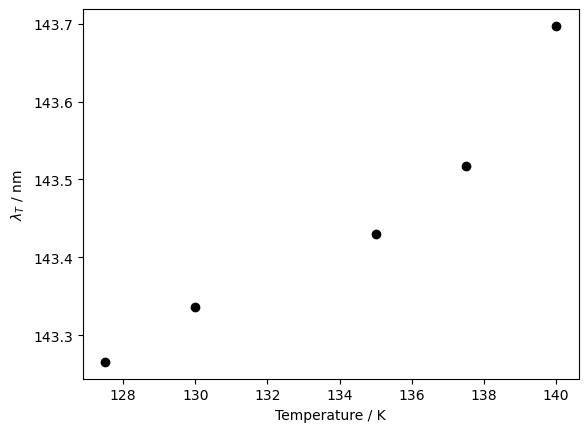

In [5]:

#extract peak positions 
os.chdir(working_dir)  
#df = pd.read_csv(filename+'.txt', delim_whitespace=True, header=None)
xdataraw = df.iloc[:,0] #Temperature K
ydataraw = df.iloc[:,1] #peak position nm

T_array=xdataraw.to_numpy()
xmin_mu=min(T_array - 2)
xmax_mu=max(T_array + 2)

xmin=min(T_array - 2)
xmax=max(T_array + 2)

plt.plot(xdataraw, ydataraw,'ko')
#plt.title('raw data '+ name)
plt.xlabel('Temperature / K')
plt.ylabel('$\lambda_{T}$ / nm')


Text(0, 0.5, 'Energy shift from $\\lambda_{0}$ / eV')

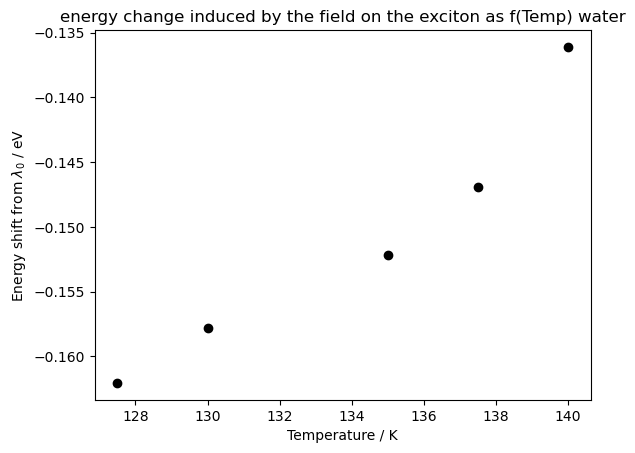

In [6]:

#Convert wavelength to eV
lambda_nm=ydataraw
lambda_eV=1239.8/lambda_nm

#Define wavelength with no field

l0_eV=1239.8/l0

#Calculate DE as -ve number (as test) i.e., long wavelength - short wavelength
DE_eV=(l0_eV-lambda_eV)
#convert things to atomic units
T=xdataraw*3.16683e-6
DE=DE_eV*0.036749405469679
r=r_nm*18.897259886  #radius in aotmic units

plt.plot(xdataraw, DE_eV,'ko')
plt.title('energy change induced by the field on the exciton as f(Temp) ' +name)
plt.xlabel('Temperature / K')
plt.ylabel('Energy shift from $\lambda_{0}$ / eV')

**Figure 4**: Makes sense that lower temperatures give a peak "futher away" from the resting value of energy, i.e., 0!

use Esp Eqn 1 
 0    7.023077e+06
1    6.869060e+06
2    6.661362e+06
3    6.466064e+06
4    6.054592e+06
Name: 1, dtype: float64
use Esp Eqn 2 
 0   -2.787245e+06
1   -2.870623e+06
2   -2.979039e+06
3   -3.076731e+06
4   -3.268818e+06
Name: 1, dtype: float64


Text(0, 0.5, 'Esp / V/m')

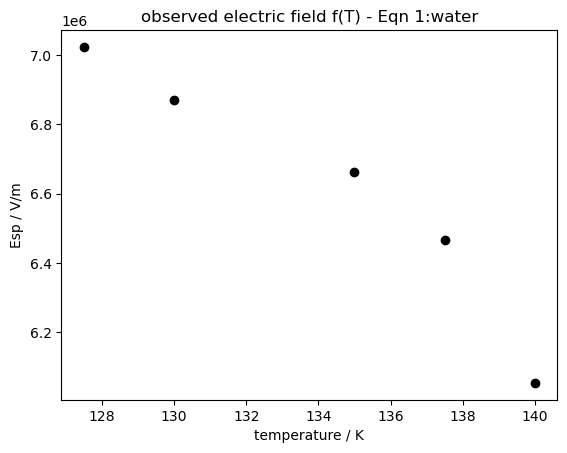

In [7]:
#David derived these equations based on the values given in the ammonia paper (see figure 3 above).
Esp_au=(1/96)*(
    -((32*DE)/r)
    +(
        (16*(2**(1/3))*DE*(6+DE*eps*r))
        /
        (r**3 *
         ((((DE**2*eps**2 *r**(0.5))*(-9+2*DE*eps*r))+3*(3**(0.5))*(-DE**3 *eps**3 *(32+DE*eps*r*(13+4*DE*eps*r)))**0.5)
          /
          (r**(9/2))
         )**(1/3)
        )
    )
    +
    (
        (8*(2**(2/3))*
         ((((DE**2 *eps**2 *r**(0.5))*(-9+2*DE*eps*r))+3*(3**(0.5))*(-DE**3 *eps**3 *(32+DE*eps*r*(13+4*DE*eps*r)))**0.5)
          /
          (r**(9/2))
         )**(1/3))
        /
        (eps))
)


Parteqn = (DE**2*eps**2*r**8*(-9+2*DE*eps*r)+3*(3**0.5)*(-DE**3*eps**3*r**15*(32+DE*eps*r*(13+4*DE*eps*r)))**0.5)**(1/3)

Esp_au_V2= (((-32*DE*r**3)
           +
           ((16*2**(1/3)*DE*r**5*(6+DE*eps*r))/Parteqn)
           +
           (Parteqn/eps))
          /
          (96*r**4))

#print(Parteqn)
print('use Esp Eqn 1 \n',  Esp_au*5.14220652e+11)
print('use Esp Eqn 2 \n',  Esp_au_V2*5.14220652e+11)# we ignore this for now



Esp_Vm=(Esp_au*5.14220652e+11)
Esp_Vm_array=Esp_Vm.to_numpy()
ymin=min(Esp_Vm_array) - 0.25*(Esp_Vm_array[-1])
ymax=max(Esp_Vm_array) + 0.22*(Esp_Vm_array[-1])

#print(name+' Esp in au:','\n', Esp_au)

plt.plot(xdataraw, Esp_Vm, 'ko')
#plt.scatter(xdataraw, )
plt.title('observed electric field f(T) - Eqn 1:'+name)
plt.xlabel('temperature / K')
plt.ylabel('Esp / V/m')

**Figure 5**: The calculated values of $E_{SP}$ as a function of T

dipole moment in the solid sate for water is 3.0001956425279994 Debye
Omega is 117.08357819767461 in au
water_radius  0.16059903423636912 nm
Calculated value of E_A for water is  6.514495965045533 x 10^10 V/m
[8.71862318e-05 8.68356095e-05 8.63519127e-05 8.58854577e-05
 8.48646314e-05]


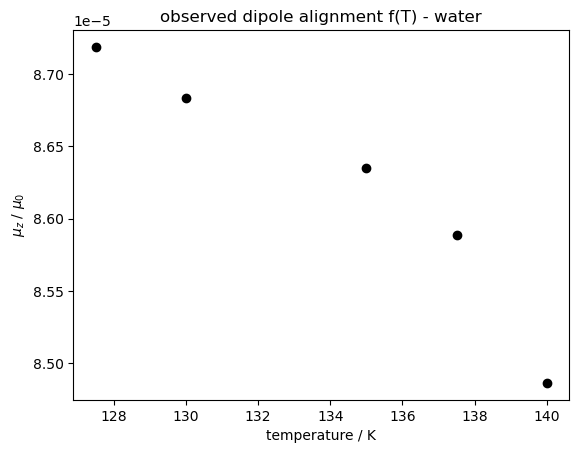

In [17]:
#Convert Esp to muz/mu0 values using a fixed value for EA value

#convert knowns into au 

s = (s_nm)*18.897  # estimated layer spacing converted to au
mu_0 = (mu_0_Debye*0.393456)  #  solid state dipole converted to au

print('dipole moment in the solid sate for '+name+' is', mu_0*2.541746, 'Debye')

Omega = Omega_SI*18897259886**3 # convert volume to au

print('Omega is '+ str(Omega) + ' in au')

water_radius_AU = ((3/(4*np.pi))**(1/3))*(Omega**(1/3))
print(name+'_radius  '+ str(water_radius_AU/18.897) + ' nm')

E_A=4*np.pi*mu_0/Omega
E_A_Vm = E_A*5.14220652e+11
print('Calculated value of E_A for '+name+' is ', E_A_Vm/1E10, 'x 10^10 V/m')

degree_of_alignment=Esp_Vm/E_A_Vm
muz_mu0_array=degree_of_alignment.to_numpy()
ymin_mu=min(muz_mu0_array) - 0.25*(muz_mu0_array[-1])
ymax_mu=max(muz_mu0_array) + 0.25*(muz_mu0_array[-1])

#print(degree_of_alignment)

plt.plot(xdataraw, degree_of_alignment, 'ko')
#plt.scatter(xdataraw, )
plt.title('observed dipole alignment f(T) - '+name)
plt.xlabel('temperature / K')
plt.ylabel('$\mu_{z}$ / $\mu_{0}$')

print(muz_mu0_array)


**Figure 6**: say what you see.

In [9]:
#Write data to text file
length=(len(T_array))
weight=np.ones(length)
err_muz_mu0=0.1*(muz_mu0_array)
err_T=np.ones(length)   #0.1*(T_array)

os.chdir(working_dir+'\\observed_data')
data=np.column_stack((weight,muz_mu0_array,err_muz_mu0,T_array,err_T,Esp_Vm_array))#,mu_0,E_A_Vm))
header='weight,y,sigma_y,Temperature,sigma_T,Observed_field'

with open('data for_'+name+'.csv', mode='w', ) as newfile: 
    np.savetxt(newfile,data, header=header,delimiter=',',comments='') 
    
os.chdir(working_dir)  


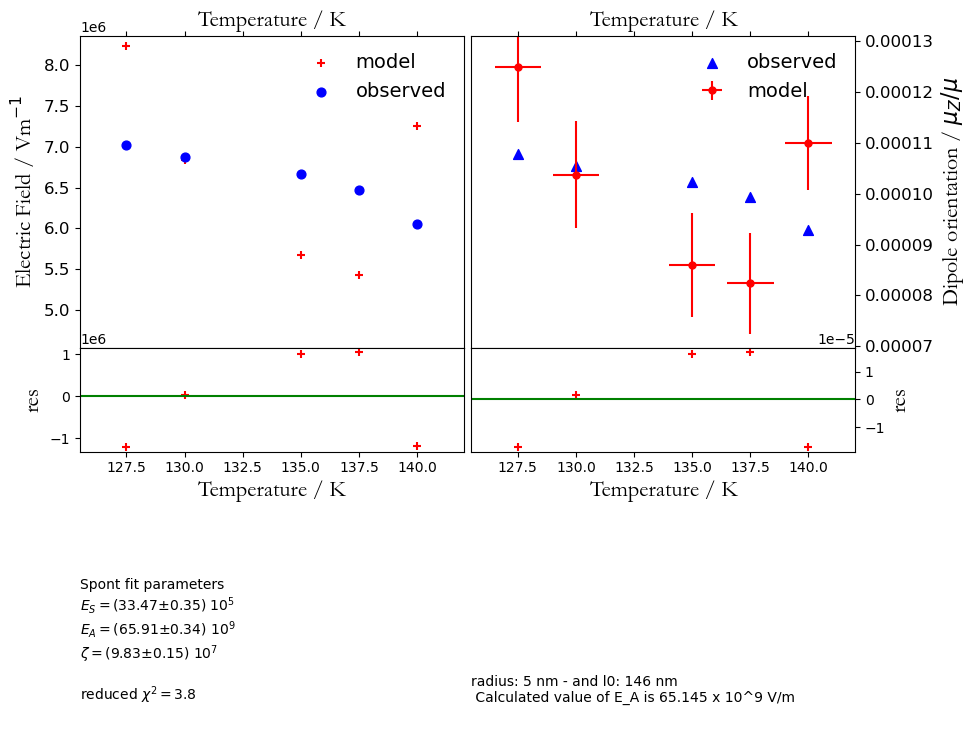

In [10]:
#run the main driver program for fitting the spontelectric model on multiple datasets
#load the datasets for each ice material
os.chdir(working_dir+'\\observed_data')
SpontelData = pandas.read_csv('data for_'+name+'.csv')
#SpontelData_dict[name] =  (SpontelData)

SpontelData.head()


    #
    # Main driver programme for fitting Spontelectric field data
    # 
    # Define several conversion factors to/from atomic units
    # conversion of Temp to a.u. : T [a.u.]= T [K]/factor
Ttoau=315770.0
    # conversion of D to a.u. : 1 D (=Debye) = factor [a.u.]
Debye=0.393456
    # Convert el. field in a.u. To V/m : E [a.u.] = E [V/m]/factor
Etoau=5.142e11
 
htfc=numpy.array([0.0]*4)
 
    # Find the value of mu for this ice 
IceMu=mu_0_Debye
    
    # Provide a first guess value for the parameter E_A
EAnxt=E_A_Vm
    
htfc[0]=1.0
htfc[1]=0.0
htfc[2]=0.0
htfc[3]=0.0
    
weight=numpy.array(SpontelData.weight)
ndata=len(weight)
    # y is the same as <mu_Z>/mu, Temp is the deposition temperature in [K]
    # sig are the 1-sigma measurement errors
    # E observed is the observed Electric field in units [V/m]
y=numpy.array(SpontelData.y)
sigy=numpy.array(SpontelData.sigma_y)
Temp=numpy.array(SpontelData.Temperature)
sigT=numpy.array(SpontelData.sigma_T)
Eobs=numpy.array(SpontelData.Observed_field)
    #
    # here comes a block of variable declarations
whtsum=0.0
yinvmn=0.0
hTfunc=numpy.array([0.0]*ndata)
DerhTfunc=numpy.array([0.0]*ndata)
DerGT=numpy.array([0.0]*ndata)
DerGy=numpy.array([0.0]*ndata)
PartDerv=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
xdat=numpy.array([[0.0]*ndata,[0.0]*ndata])
ydat=numpy.array([0.0]*ndata)
zdat=numpy.array([0.0]*ndata)
ymodel=numpy.array([0.0]*ndata)
DParDy=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
DParDT=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
SigPar=numpy.array([0.0]*3)
#
#
# Auxiliary functions f_0, f_1, f_2, and f_3 are needed as input for linear least-squares
# These are named here as PartDerv[0,], ..., PartDerv[3,] because these are also the
# partial derivatives of the function G with respect to T and y.
for i in range(0,ndata):
    yinvmn+=weight[i]/y[i]
    whtsum+=weight[i]
    hTfunc[i]=htfc[0]+Temp[i]*(htfc[1]+Temp[i]*(htfc[2]+Temp[i]*htfc[3]))
    DerhTfunc[i]=htfc[1]+Temp[i]*(2.0*htfc[2]+3.0*Temp[i]*htfc[3])
    PartDerv[0,i]=(1-y[i])*LangevInv(y[i])
    PartDerv[1,i]=Ttoau*Debye*IceMu*(y[i]-1.0)/Temp[i]
    PartDerv[2,i]=-1.0*PartDerv[1,i]*y[i]
    PartDerv[3,i]=PartDerv[1,i]*y[i]*y[i]*hTfunc[i]
#
# start the iteration to get the parameters, initialise a choice for E_A
yinvmn=yinvmn/whtsum
EAcur=1.1*EAnxt
itcnt=0
while ((abs(EAnxt/EAcur-1.0)>1.0e-3) and (itcnt<20)) :
    itcnt+=1
    EAcur=EAnxt
    for i in range(0,ndata):
        xdat[0,i]=PartDerv[1,i]
        xdat[1,i]=PartDerv[3,i]
        ydat[i]=-1.0*(PartDerv[0,i]+EAcur*PartDerv[2,i]/Etoau)
#
    Constrout=ConstrLSQ(xdat,ydat,weight)
#
# FPP (02/06/2022): here E_S and zeta always are forced to be >= 0
    EScur=abs(Constrout[0]*Etoau)
    ESzetacur=abs(Constrout[1]*Etoau)
    ratiolog=0.0
    for i in range(0,ndata) :
        Ezmod=(EScur-EAcur*y[i]+ESzetacur*hTfunc[i]*y[i]*y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i]
        ratiolog+=weight[i]*(math.log(abs(EAcur*Langevin(Ezmod)))-math.log(Eobs[i]))
        DerGy[i]=(EScur-ESzetacur*hTfunc[i]*y[i]*(2.0-3.0*y[i])+EAcur*(1.0-2.0*y[i]))*IceMu*Ttoau*Debye/Etoau/Temp[i]
        DerGy[i]+=-1.0*LangevInv(y[i])+(1.0-y[i])*DerLangevInv(y[i])
        DerGT[i]=(EScur*(1-y[i])-EAcur*y[i]*(1-y[i])+ESzetacur*hTfunc[i]*y[i]*y[i]*(1-y[i]))*IceMu*Ttoau*Ttoau*Debye/Etoau/Temp[i]/Temp[i]
        DerGT[i]+=-1.*ESzetacur*DerhTfunc[i]*y[i]*y[i]*(1-y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i]
    ratiolog=ratiolog/whtsum
    if ((Constrout[0]<0) and (EAcur<0) and (yinvmn<0) and (ratiolog>0)) :
        EAnxt=EAcur+2.0*yinvmn*EScur
    else :
        EAnxt=EAcur/math.exp(ratiolog)
    if (itcnt>40) : 
        print ("iteration count exceeded: not converged")
#
# G(T,y)\equiv\left(1-y\right)L^{-1}(y)-\frac{\mu}{T}\left\{ E_S\left[1-y+\zeta (y^2 -y^3)\right] 
#          -E_A(y-y^2) \right\}
# dG/dy=-L^{-1}(y)+\left(1-y\right)\frac{\d L^{-1}(y)}{dy}-\frac{\mu}{T}\left\{ 
#           E_S\left[-1+\zeta h(T) (2y -3y^2)\right] -E_A(1-2y) \right\}
# dG/dT=\frac{\mu}{T^2}\left\{ E_S\left[1-y+\zeta_0 h(T) (y^2 -y^3)\right] -E_A(y-y^2) \right\}-\frac{\mu}{T}
#           E_S\zeta_0\frac{d h(T)}{dT} (y^2 -y^3)
#
# for the calculation of the uncertainty margins for the parameters the partial derivatives below are needed
#
# also calculate the quality of the fit (chi-square) dlsqsum
dlsqsum=0
for i in range(0,ndata) :
    ymodel[i]=Langevin((EScur-EAcur*y[i]+ESzetacur*hTfunc[i]*y[i]*y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i])
    DelMod=y[i]-ymodel[i]
    dlsqsum+=weight[i]*DelMod*DelMod/sigy[i]/sigy[i]
        #print(i,weight[i]*DelMod*DelMod/sigy[i]/sigy[i])
    DParDy[0,i]=-1.0*DerGy[i]/PartDerv[1,i]
    DParDy[1,i]=-1.0*DerGy[i]/PartDerv[2,i]
    DParDy[2,i]=-1.0*DerGy[i]/PartDerv[3,i]
    DParDT[0,i]=-1.0*DerGT[i]/PartDerv[1,i]
    DParDT[1,i]=-1.0*DerGT[i]/PartDerv[2,i]
    DParDT[2,i]=-1.0*DerGT[i]/PartDerv[3,i]
#
dlsqsum=dlsqsum/(whtsum-2)
# calculate the 1-sigma uncertainties for the parameters
for k in range(0,3):
    for i in range(0,ndata) :
        SigPar[k]+=weight[i]*(DParDy[k,i]*DParDy[k,i]*sigy[i]*sigy[i]+DParDT[k,i]*DParDT[k,i]*sigT[i]*sigT[i]/Ttoau/Ttoau)
    SigPar[k]=Etoau*math.sqrt(SigPar[k]/whtsum)

#set up figures to show fit results
#ymin_mu=(SpontelData.ymin.iloc[0])
#ymax_mu=(SpontelData.ymax.iloc[0])
#xmin_mu=(SpontelData.xmin.iloc[0])
#xmax_mu=(SpontelData.xmax.iloc[0])
#ymin=(SpontelData.ymin.iloc[1])
#ymax=(SpontelData.ymax.iloc[1])
#xmin=(SpontelData.xmin.iloc[1])
#xmax=(SpontelData.xmax.iloc[1])
#ticks=[SpontelData.ticks.iloc[0:3]]
  
zetacur=ESzetacur/EScur
ymodel_E=EAcur*ymodel

#Define text to print on each graph
SigPar[2]=zetacur*math.sqrt(SigPar[2]*SigPar[2]/ESzetacur/ESzetacur+SigPar[0]*SigPar[0]/EScur/EScur)
string = 'Spont fit parameters'
string+="\n"+"$E_S =$"+NeaterOut(EScur,SigPar[0])
string+="\n"+"$E_A =$"+NeaterOut(EAcur,SigPar[1])
string+="\n"+"$\zeta =$"+NeaterOut(zetacur,SigPar[2])
string+="\n\n"+"reduced $\chi^2 =$"+'{0:.1f}'.format(dlsqsum)+"\n"

annotate=(string)

#define residuals for plot (just for visualising)
res_E=Eobs-ymodel_E
res_mu=y-ymodel
      
#FigureMu(Temp,ymodel,y,sigT,sigy,xmin_mu,xmax_mu,ymin_mu,ymax_mu,name)
#ymodel=EAcur*ymodel
#FigureE(Temp,ymodel,Eobs,xmin,xmax,ymin,ymax,name)


fig, ax = plt.subplots(2, 2, sharex=True, gridspec_kw={'height_ratios':[3,1]}, figsize=(10, 5.4))
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0.02)
        
#plt.title(ij_space)
ax[0,0].set_xlim(xmin, xmax)
ax[0,0].set_ylim(ymin, ymax)
ax[0,0].scatter(Temp, ymodel_E, marker='+', s=40, color='red', label='model')
ax[0,0].scatter(Temp, Eobs, marker='o', s=40, color='blue', label='observed')
    #ax.set_yticks(tick)
ax[0,0].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
ax[0,0].xaxis.set_label_position("top")
ax[0,0].xaxis.tick_top()
ax[0,0].set_ylabel('Electric Field / Vm$^{-1}$', fontsize=16, fontname='garamond')
ax[0,0].tick_params(labelsize='large')
ax[0,0].legend(loc=0, fontsize=14, framealpha=0)
ax[0,0].text(xmin,0,annotate)
    
ax[0,1].set_xlim(xmin_mu, xmax_mu)
ax[0,1].set_ylim(ymin_mu, ymax_mu)
ax[0,1].errorbar(Temp, ymodel, markersize=10, xerr=sigT, yerr=sigy, fmt='.', color='red', label='model')
ax[0,1].scatter(Temp, y, marker='^', s=50, color='blue', label='observed')
ax[0,1].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
ax[0,1].xaxis.set_label_position("top")
ax[0,1].xaxis.tick_top()
ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].set_ylabel('Dipole orientation / $\mu_Z/\mu$', fontsize=16, fontname='garamond')
ax[0,1].tick_params(labelsize='large')
ax[0,1].legend(loc=0, fontsize=14, framealpha=0)
ax[0,1].text(xmin_mu,0,ij_space+'\n Calculated value of E_A is '+str(round(E_A_Vm/1E9,3))+' x 10^9 V/m')
#ax[0,1].text(20,0,legend_mu)
    
ax[1,0].scatter(Temp, res_E, marker='+', s=40, color='red', label='observed')
ax[1,0].axhline(y = 0.0, color = 'g', linestyle = '-')
ax[1,0].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
ax[1,0].set_ylabel('res', fontsize=16, fontname='garamond')
    
ax[1,1].scatter(Temp, res_mu, marker='+', s=40, color='red', label='observed')
ax[1,1].yaxis.set_label_position("right")
ax[1,1].axhline(y = 0.0, color = 'g', linestyle = '-')
ax[1,1].yaxis.tick_right()
ax[1,1].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
ax[1,1].set_ylabel('res', fontsize=16, fontname='garamond')





short_ij=('r_'+str(r)+'_lambda0_'+str(l0))
plt.savefig('Spont fit for'+short_ij+'.png')    
    
zetacur=ESzetacur/EScur
        
SigPar[2]=zetacur*math.sqrt(SigPar[2]*SigPar[2]/ESzetacur/ESzetacur+SigPar[0]*SigPar[0]/EScur/EScur)
string = name
string+="<br>"+"$E_S =$"+NeaterOut(EScur,SigPar[0])
string+="<br>"+"$E_A =$"+NeaterOut(EAcur,SigPar[1])
string+="<br>"+"$\zeta =$"+NeaterOut(zetacur,SigPar[2])
string+="<br><br>"+"reduced $\chi^2 =$"+'{0:.1f}'.format(dlsqsum)+"<br>"
#display(Markdown(string)) #Use this line to see the individual results for fitting parameters per dataset
    
ES=NeaterOut(EScur,SigPar[0])
EA=NeaterOut(EAcur,SigPar[1])
zeta=NeaterOut(zetacur,SigPar[2])
    
os.chdir(working_dir)    

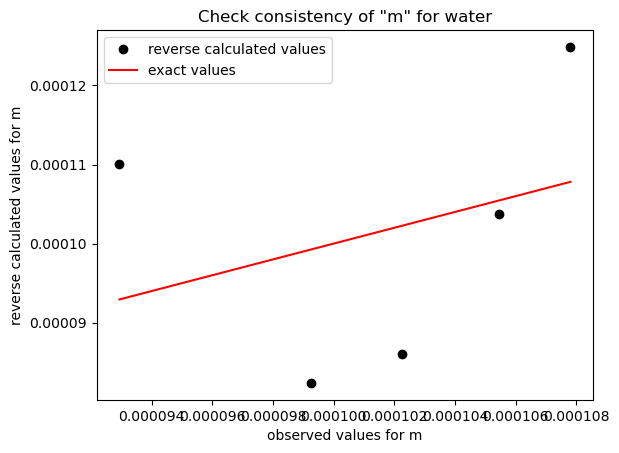

In [11]:
#Need a consistency check to make sure that the calculated fitting parameters give sensible values of dipole alignment

#**NOTE: Everything in au!**

ES_test=(EScur/5.14220652e+11)
EA_test=(EAcur/5.14220652e+11)
zeta_test=(zetacur)

m_check= - (T/(mu_0*((-EA_test*muz_mu0_array)+ES_test*(1+(muz_mu0_array**2)*zeta_test)))) + 1/(np.tanh((mu_0*(-EA_test*muz_mu0_array+ES_test*(1+(muz_mu0_array**2)*zeta_test)))/T))
figofmerit= np.sum(((m_check-muz_mu0_array)**2)**0.5) #some estimate of errors based on least squares regression


plt.plot(muz_mu0_array,m_check,'ko', label = 'reverse calculated values')
plt.plot(muz_mu0_array,muz_mu0_array,'r', label = 'exact values')


plt.xlabel('observed values for m')
plt.ylabel('reverse calculated values for m')
plt.title('Check consistency of "m" for '+name)
plt.legend()




I have a mesh with  5  values of r;  7  values of l0 and  5  spaces for E field values


C:\Users\au302163\AppData\Local\Temp\ipykernel_144\1381987492.py:252: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2, 2, sharex=True, gridspec_kw={'height_ratios':[3,1]}, figsize=(10, 5.4))


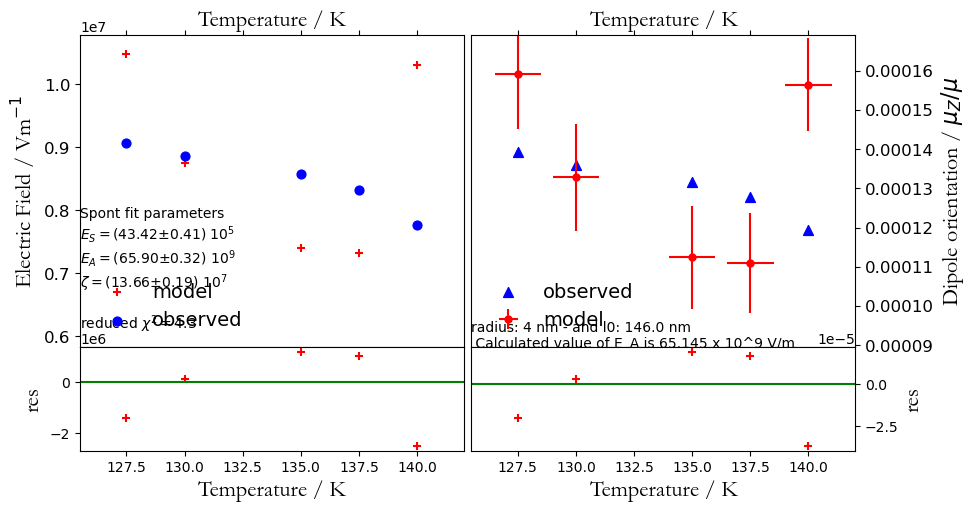

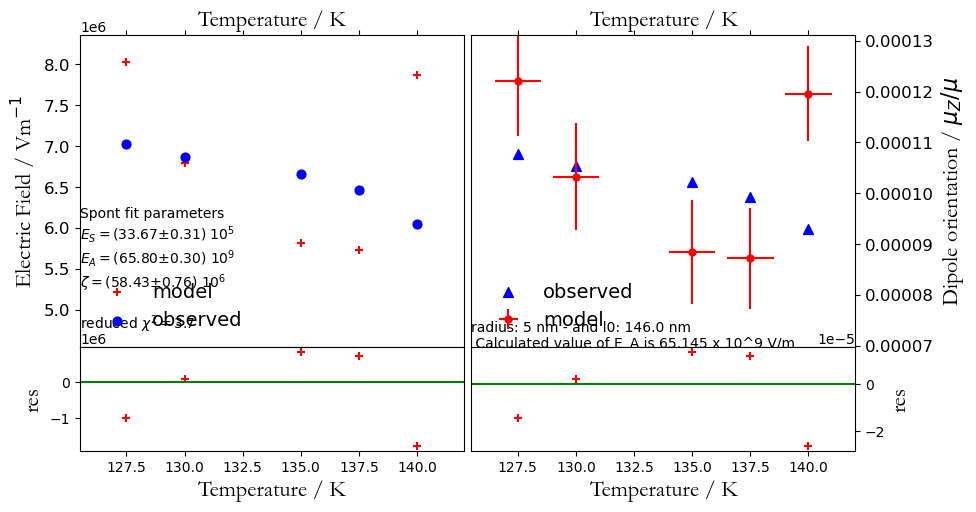

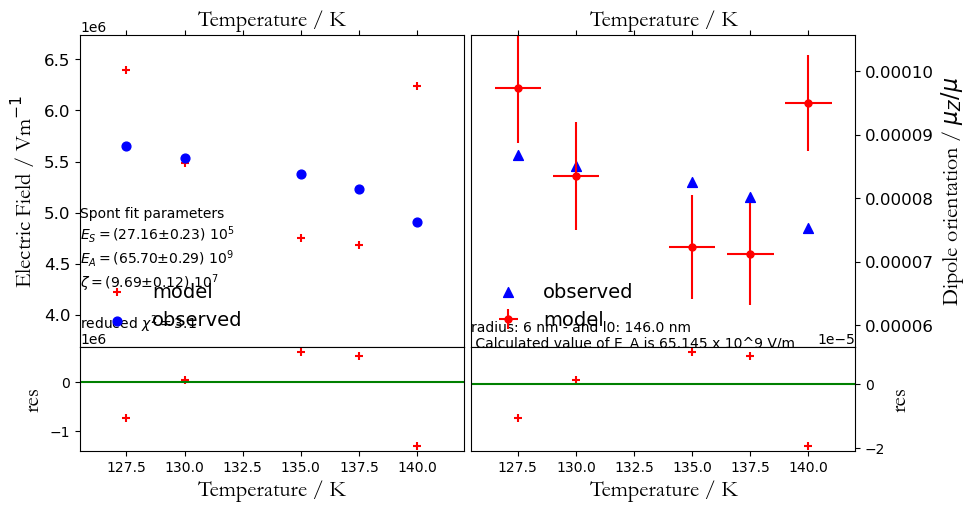

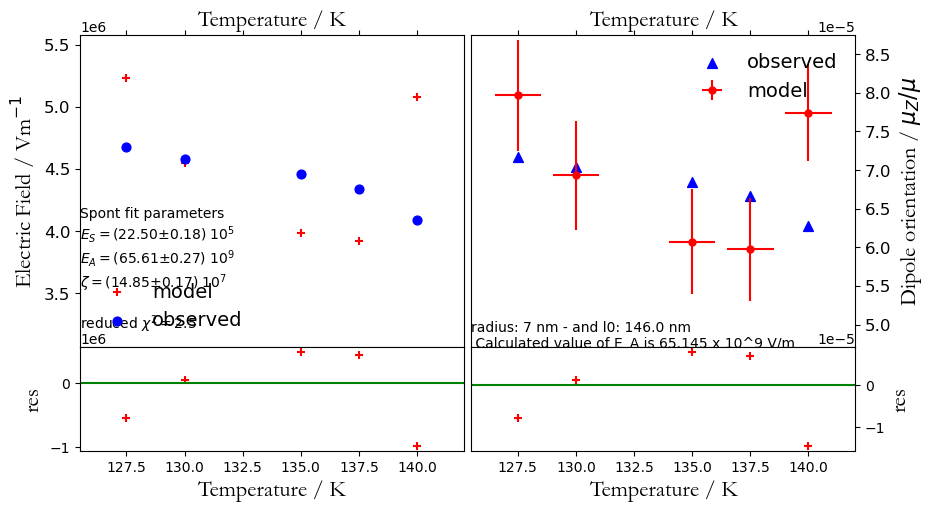

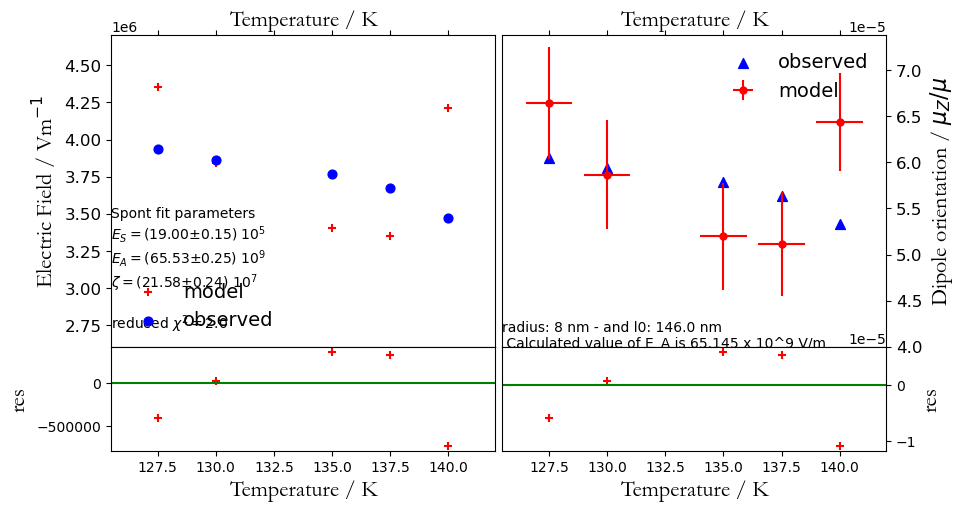

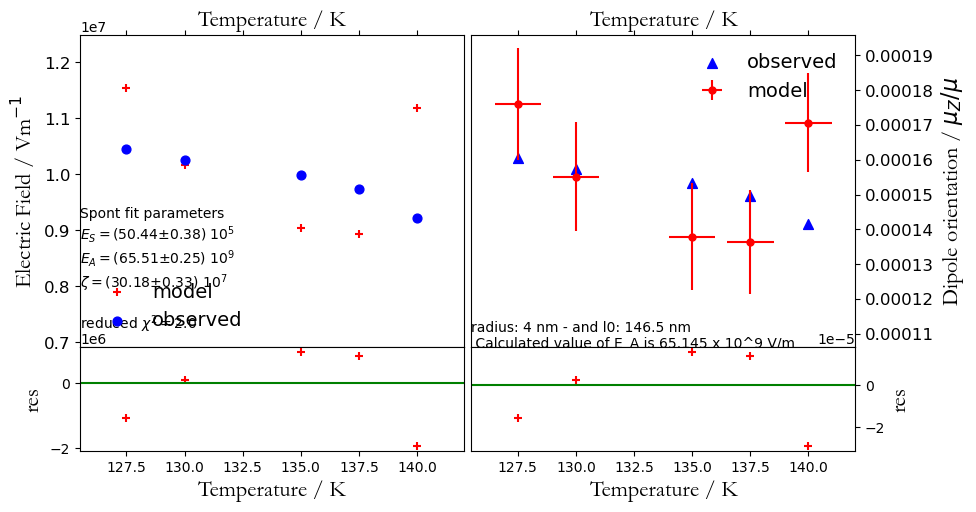

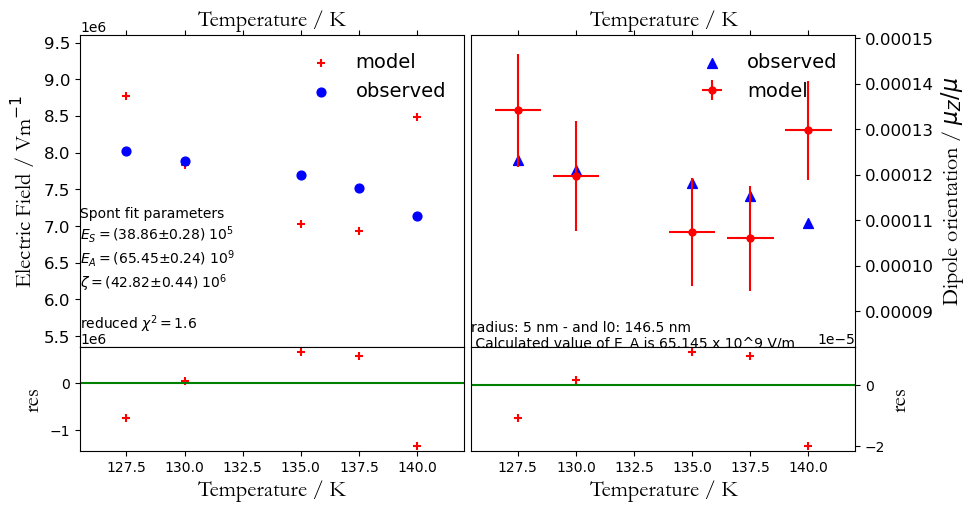

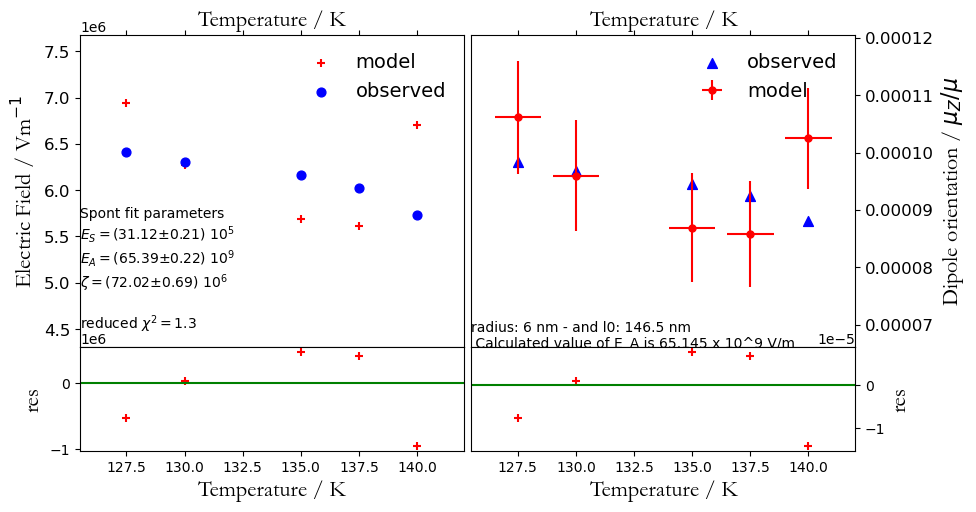

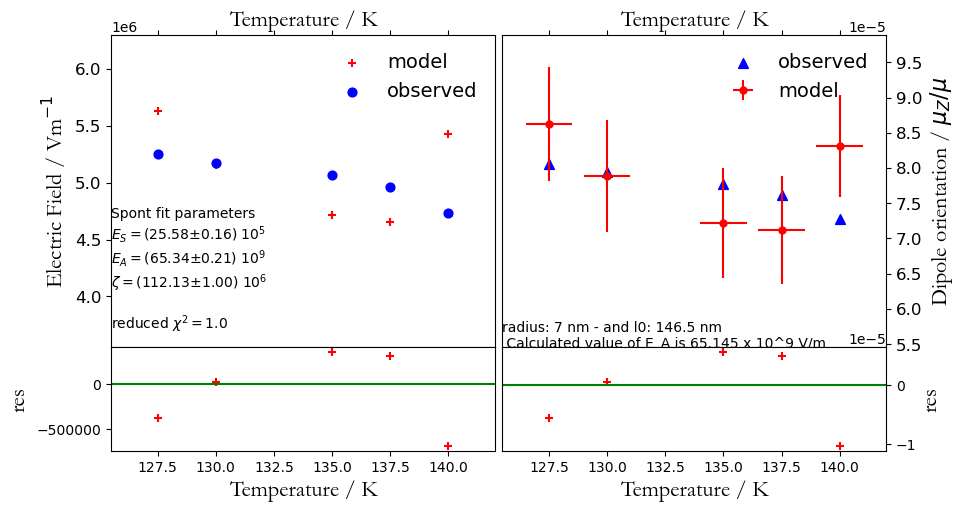

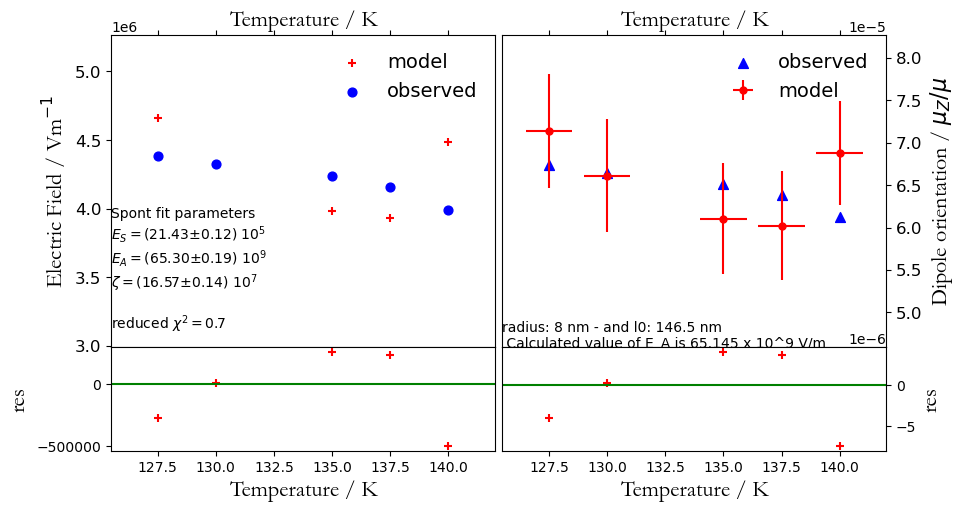

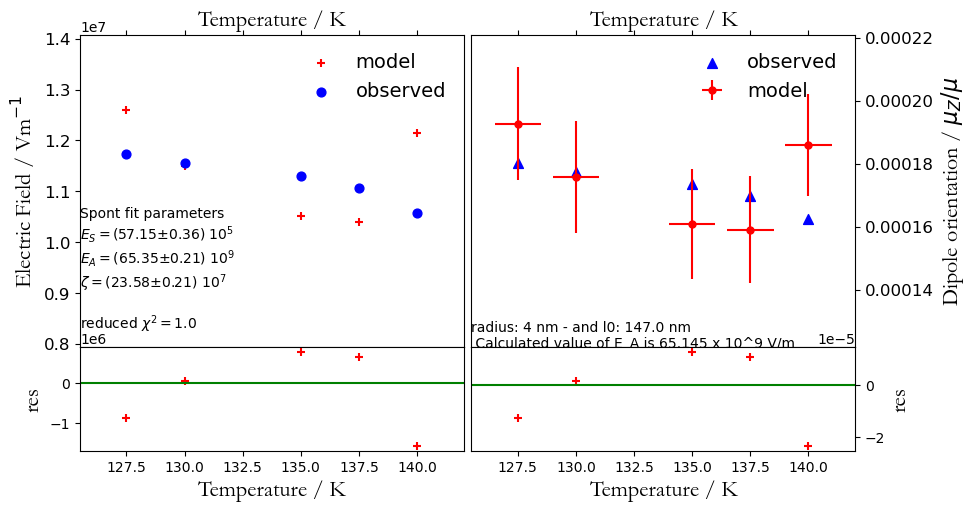

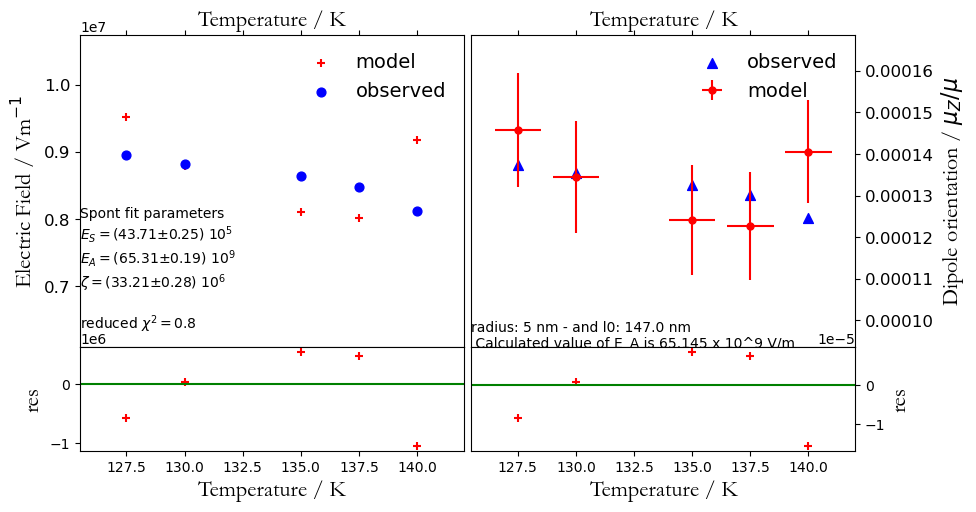

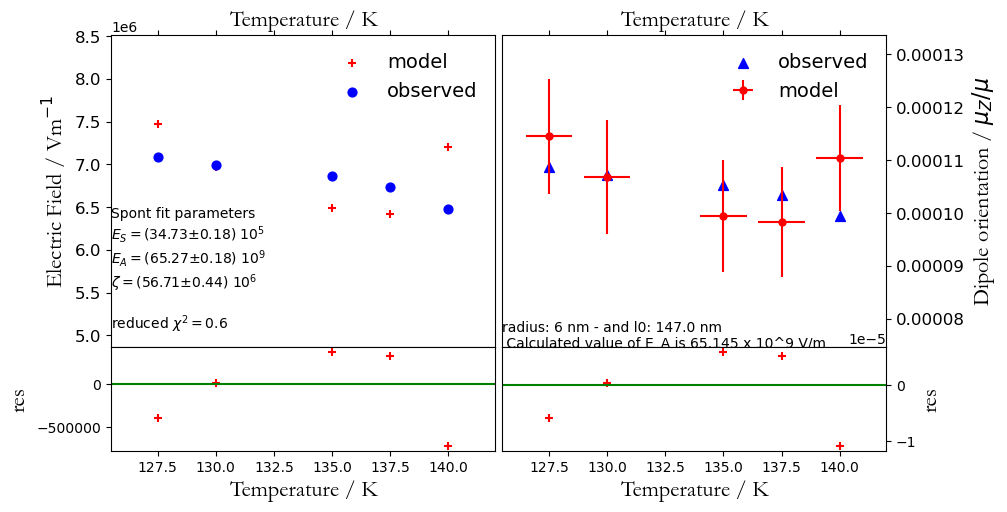

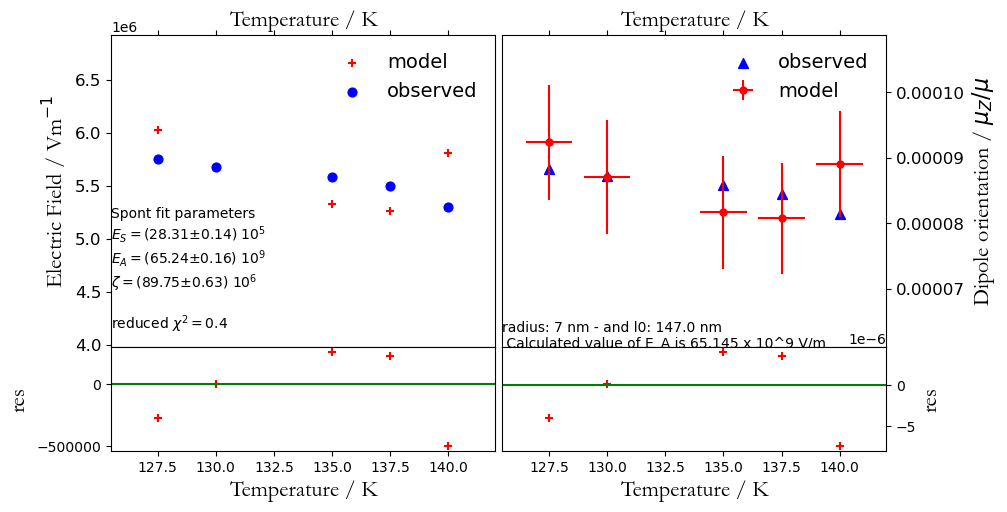

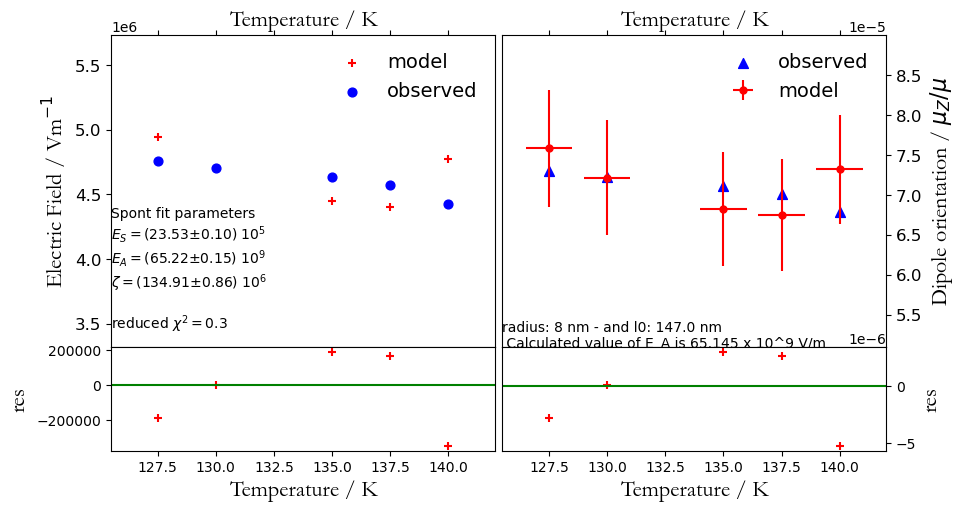

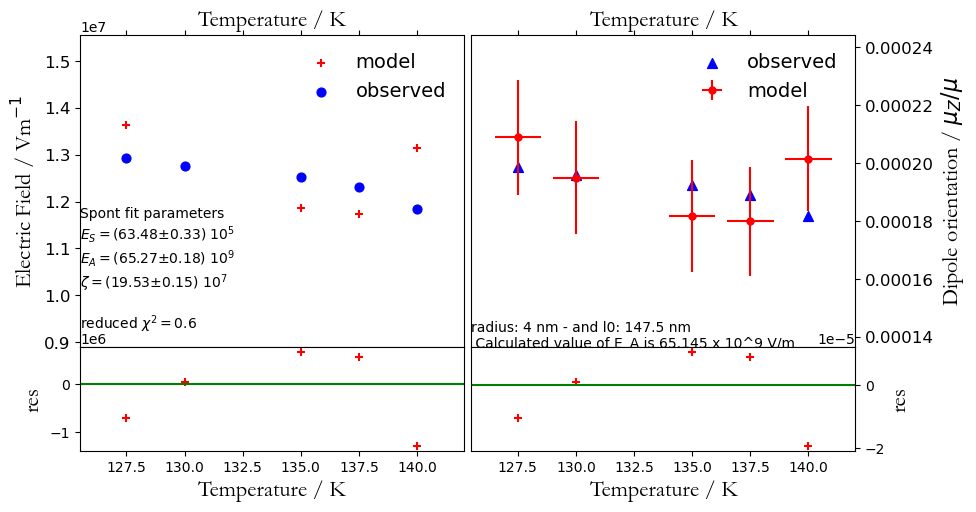

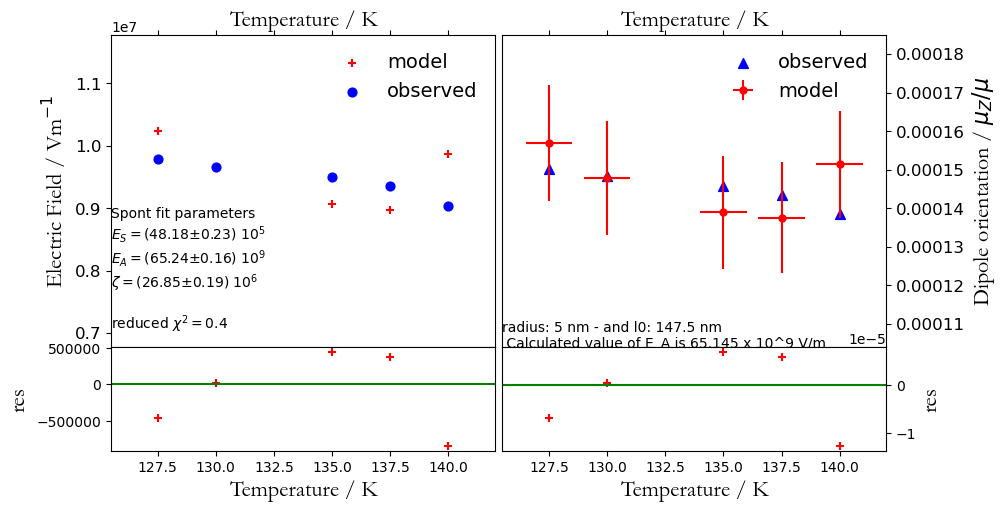

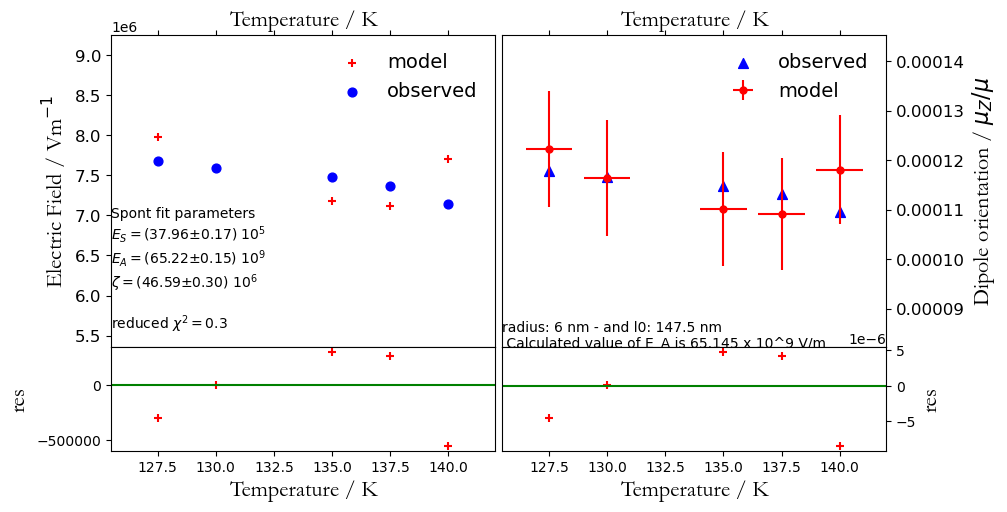

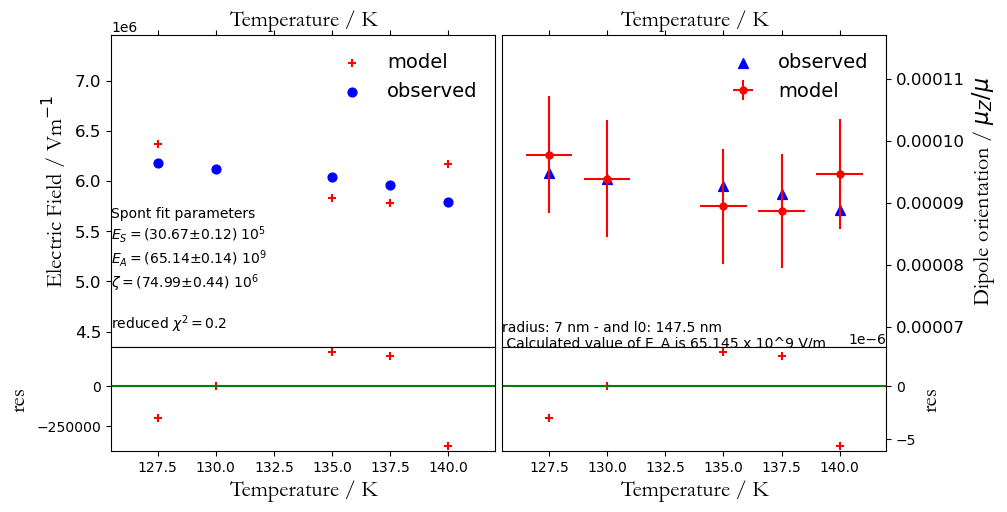

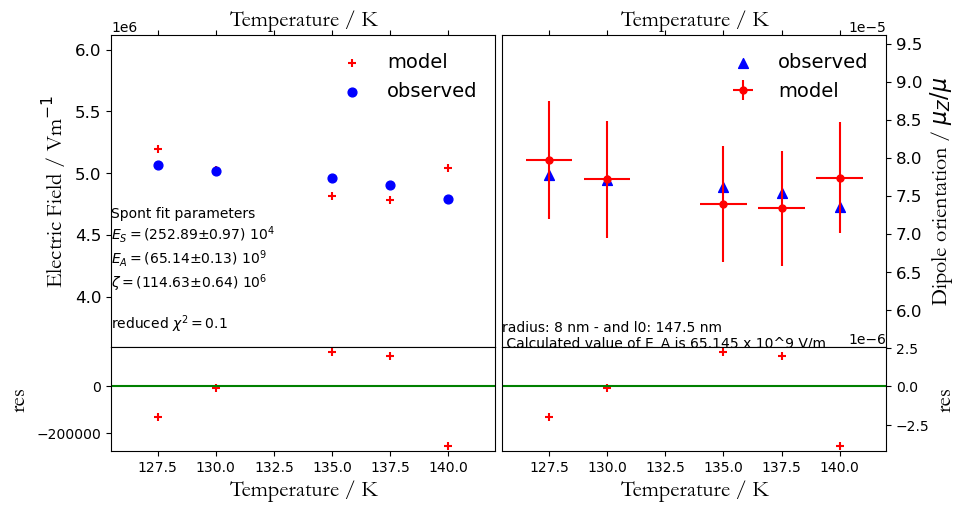

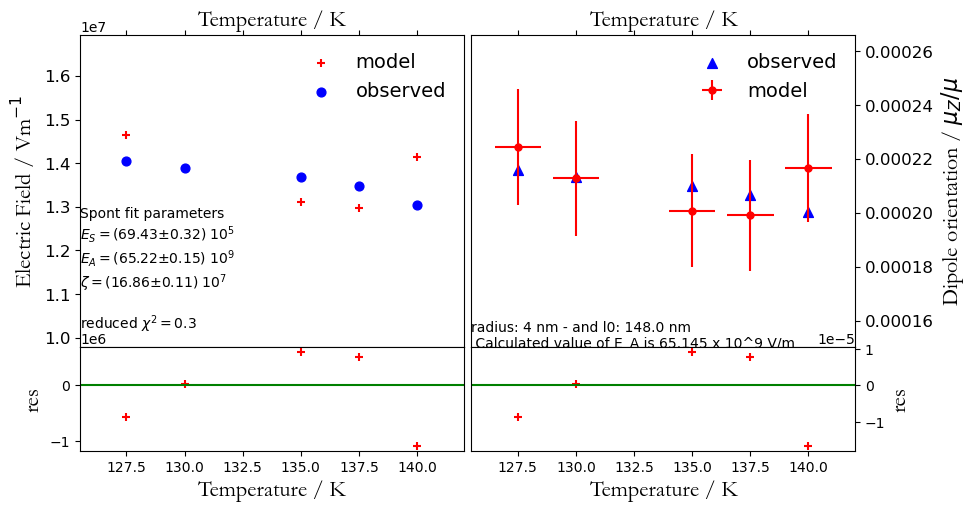

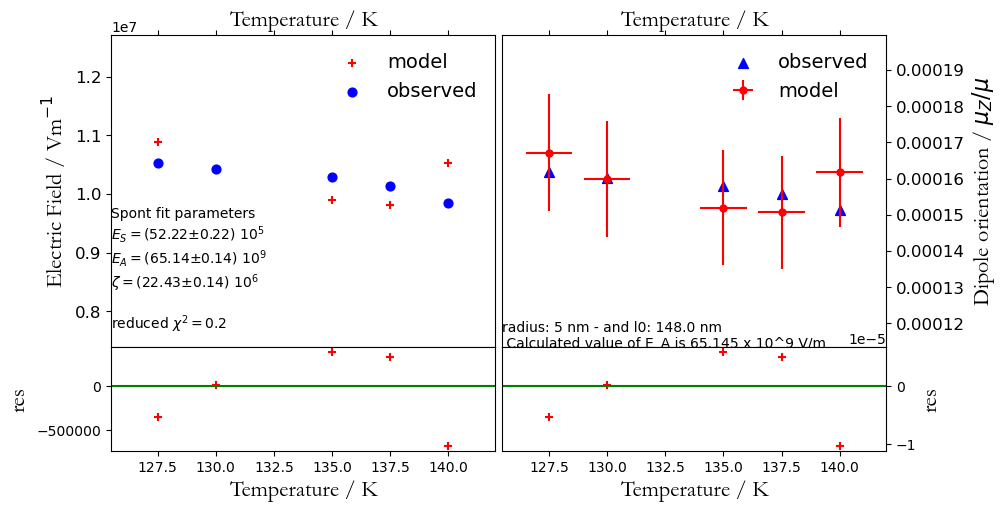

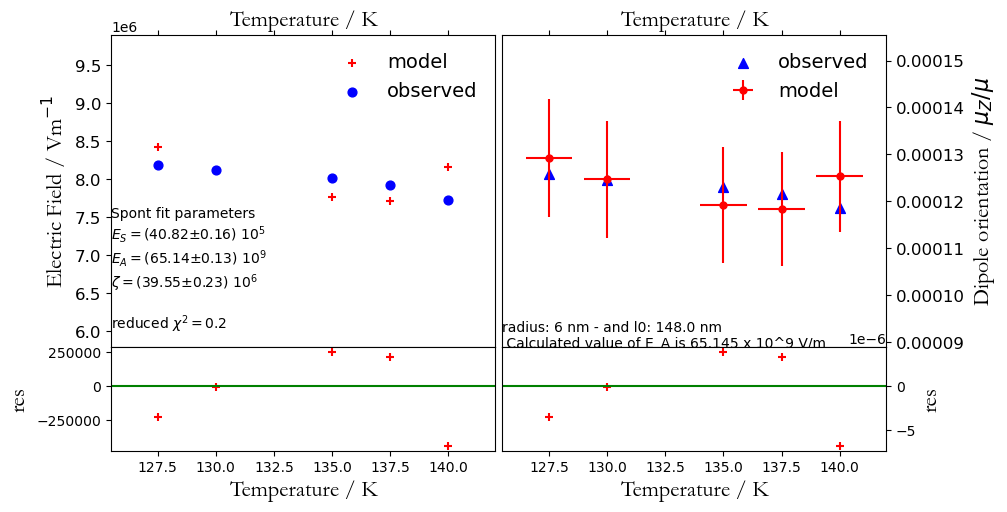

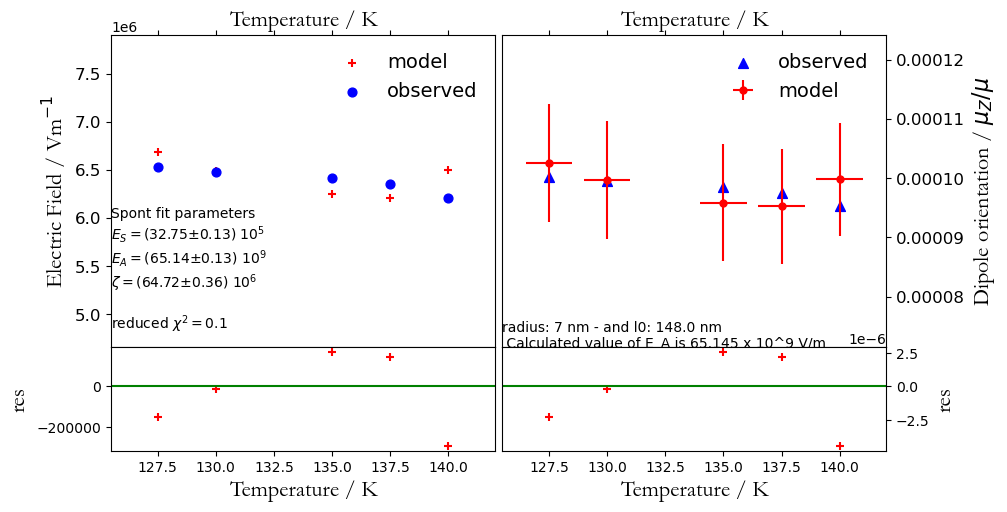

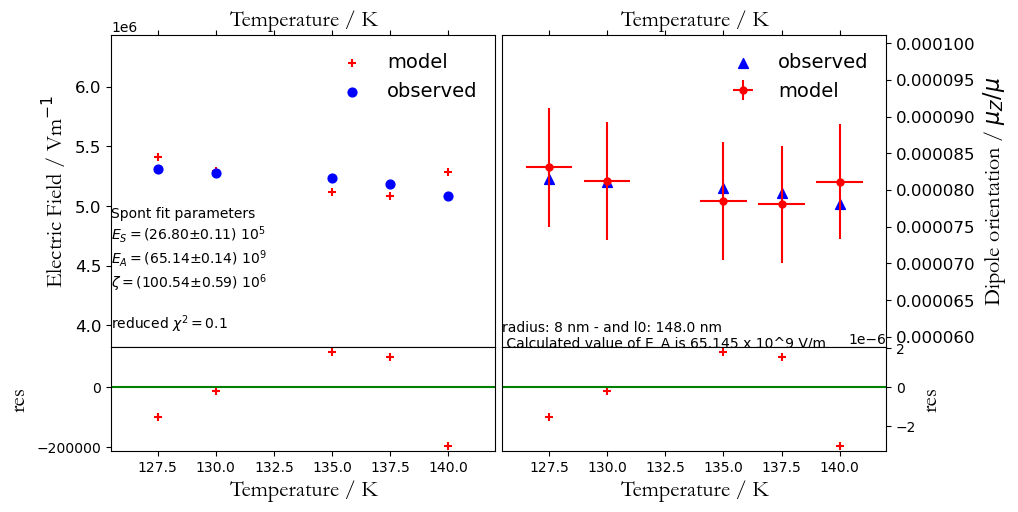

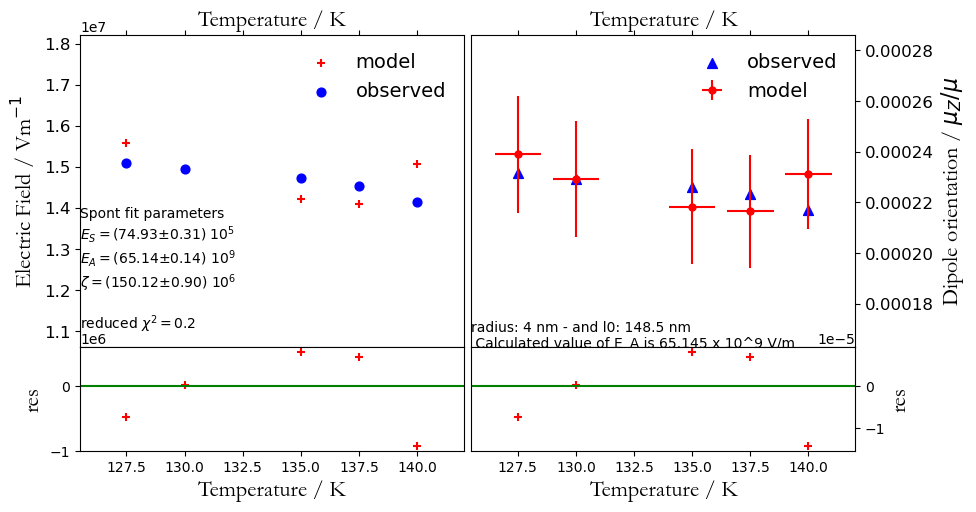

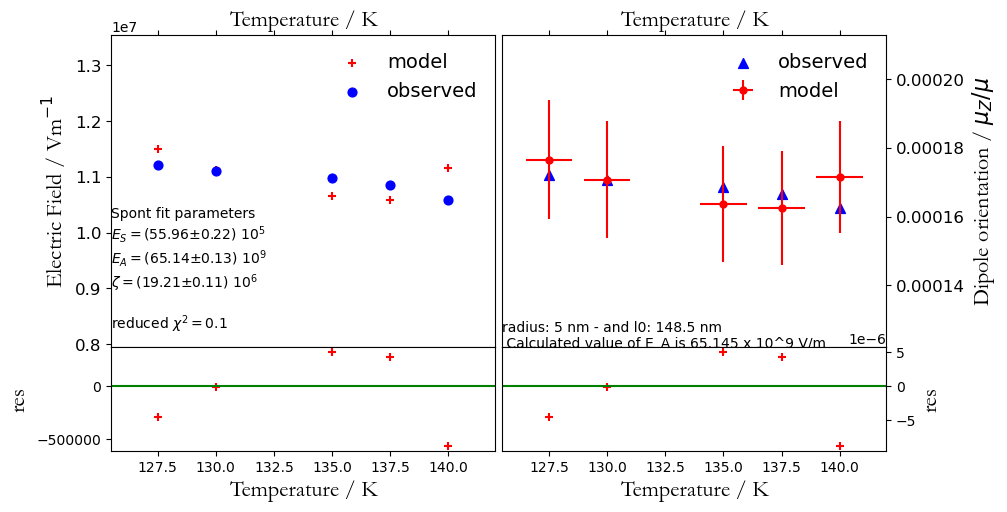

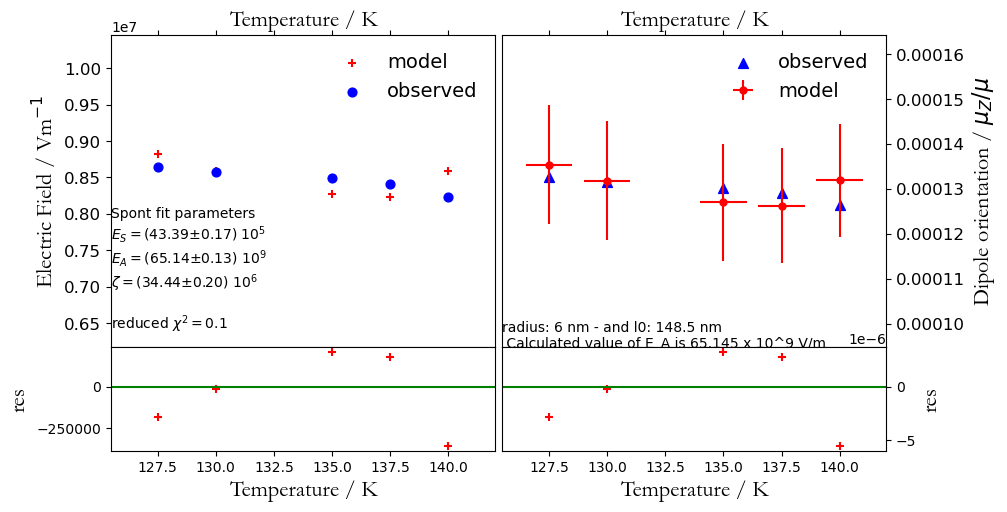

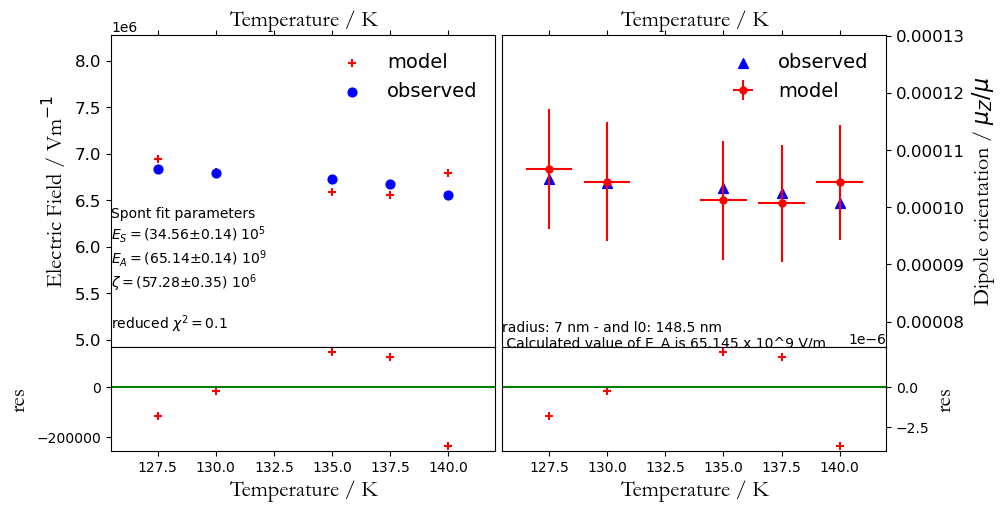

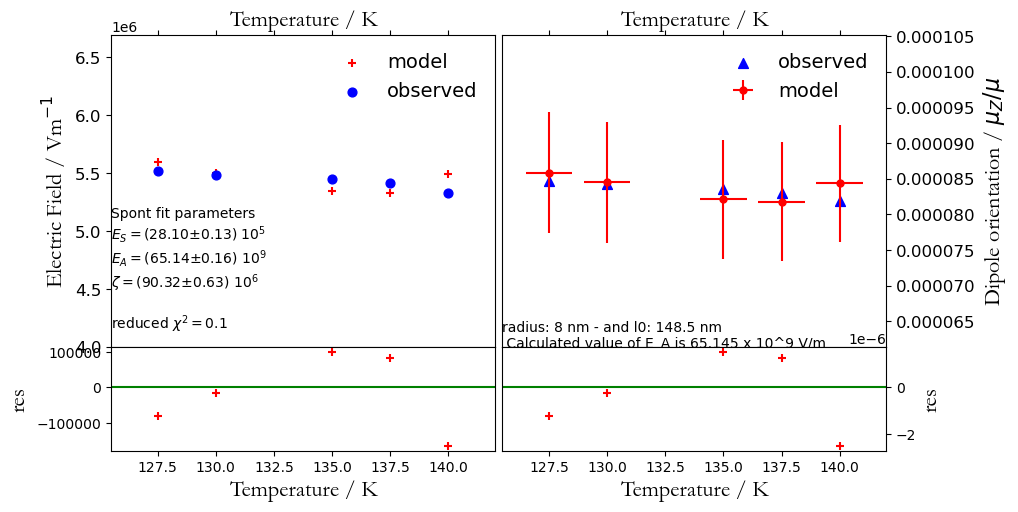

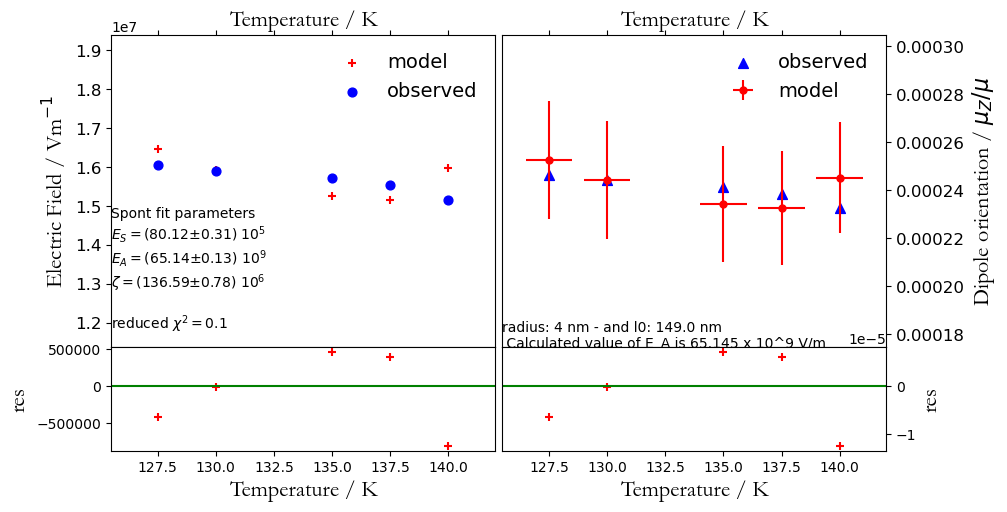

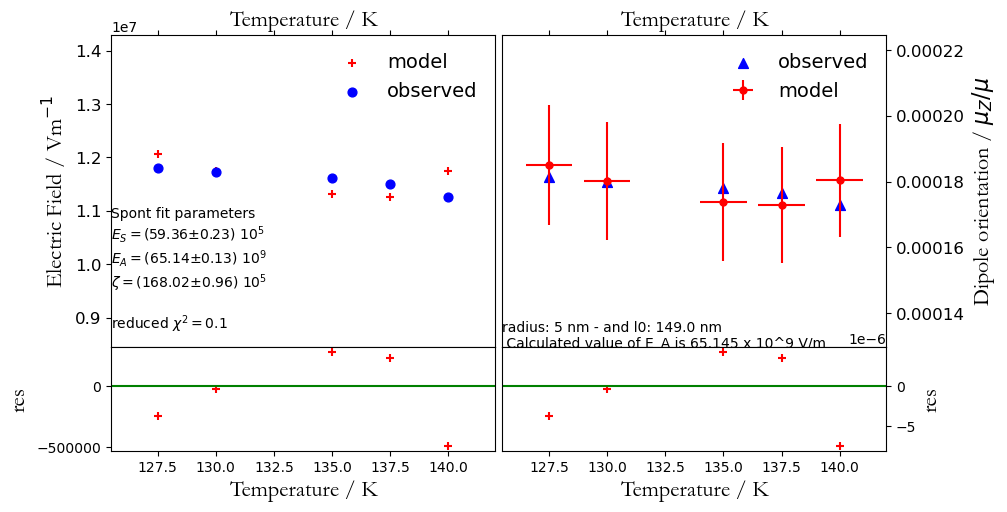

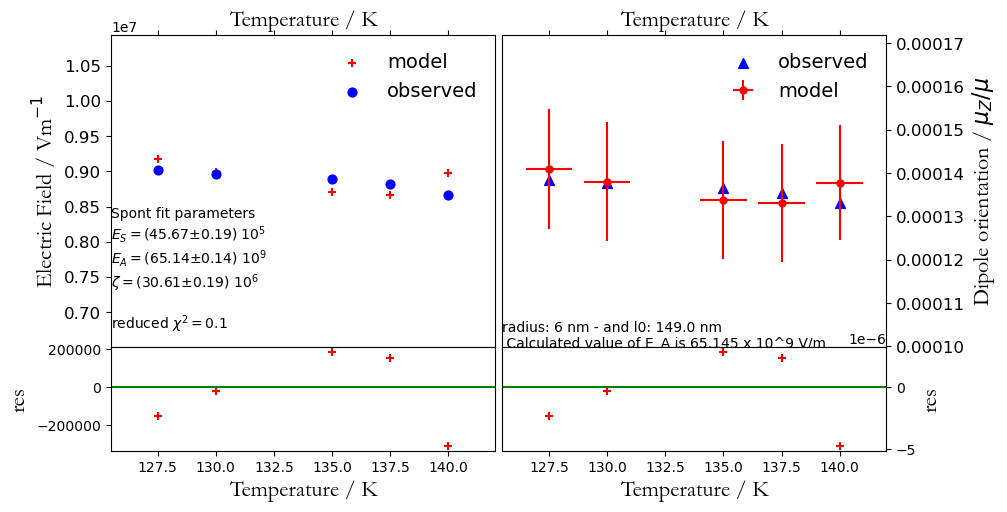

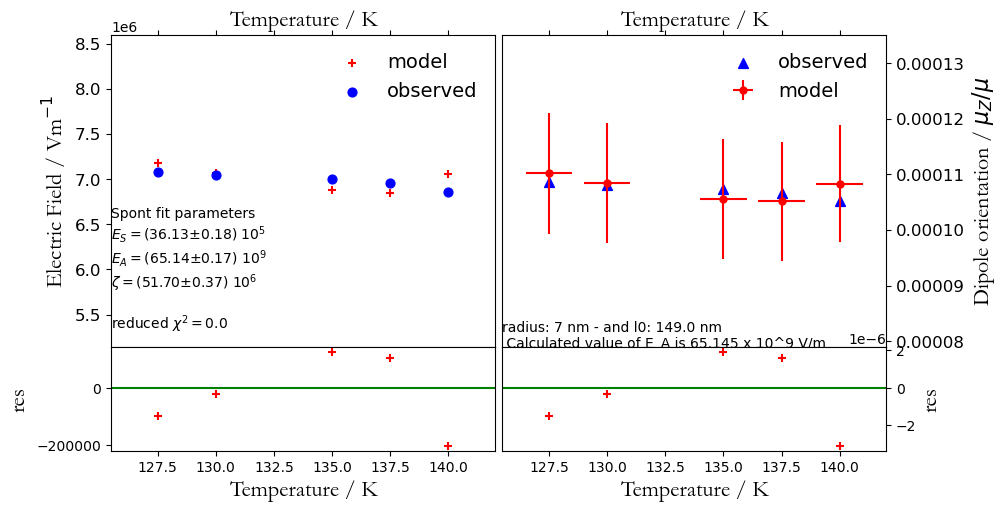

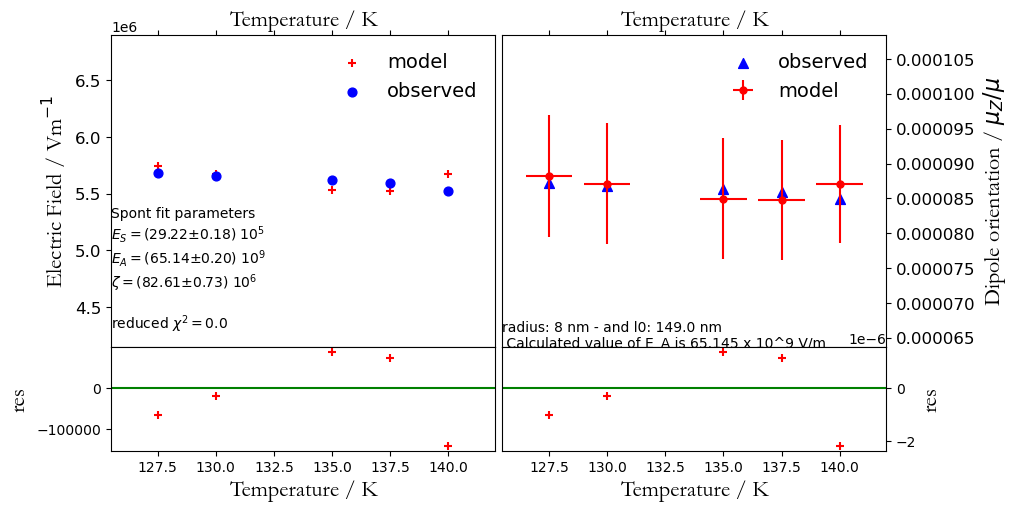

In [14]:

r_nm_values = np.array([4,5,6,7,8])
l0_values = np.array([146,146.5,147,147.5,148,148.5,149])

r_nm_values_2D, l0_values_2D = np.meshgrid(r_nm_values, l0_values)
r_nm_values_3D, l0_values_3D, Efield_3D = np.meshgrid(r_nm_values, l0_values, Temp)

chi2_values = np.zeros(r_nm_values_2D.shape)
figofmerit_values_m = np.zeros(r_nm_values_2D.shape)
figofmerit_values_E = np.zeros(r_nm_values_2D.shape)
all_obs_E_field = np.zeros(r_nm_values_3D.shape)

print('I have a mesh with ', r_nm_values_3D.shape[1], ' values of r; ', r_nm_values_3D.shape[0] ,' values of l0 and ', r_nm_values_3D.shape[2],' spaces for E field values')

for loop_index_i in range(r_nm_values_2D.shape[0]):
    for loop_index_j in range(r_nm_values_2D.shape[1]):
        #define i and j place in the matrix by scrolling through r and l0 values
        r_nm = r_nm_values_2D[loop_index_i, loop_index_j]
        l0 = l0_values_2D[loop_index_i, loop_index_j]
        r_i=str(r_nm)
        l0_j=str(l0)
        ij_space=('radius: '+r_i+' nm - and l0: '+l0_j+' nm')
        
        #find the peak fit data
        os.chdir(working_dir)  
        df = pd.read_csv(filename+'.txt', delim_whitespace=True, header=None)
        xdataraw = df.iloc[:,0] #Temperature K
        ydataraw = df.iloc[:,1] #peak position nm
        
        #set up some graph parameters
        T_array=xdataraw.to_numpy()
        xmin_mu=min(T_array - 2)
        xmax_mu=max(T_array + 2)

        xmin=min(T_array - 2)
        xmax=max(T_array + 2)
        
        #convert units
        lambda_nm=ydataraw
        lambda_eV=1239.8/lambda_nm
        l0_eV=1239.8/l0

        DE_eV=(l0_eV-lambda_eV)
        #convert things to atomic units
        T=xdataraw*3.16683e-6
        DE=DE_eV*0.036749405469679
        r=r_nm*18.897259886  #radius in atomic units

        #Calculate the "observed" value of E field, based on an exciton expansion model        
        Esp_au=(1/96)*(
            -((32*DE)/r)
            +(
                (16*(2**(1/3))*DE*(6+DE*eps*r))
                /
                (r**3 *
                ((((DE**2*eps**2 *r**(0.5))*(-9+2*DE*eps*r))+3*(3**(0.5))*(-DE**3 *eps**3 *(32+DE*eps*r*(13+4*DE*eps*r)))**0.5)
                /
                (r**(9/2))
                )**(1/3)
                )
            )
            +
            (
                (8*(2**(2/3))*
                ((((DE**2 *eps**2 *r**(0.5))*(-9+2*DE*eps*r))+3*(3**(0.5))*(-DE**3 *eps**3 *(32+DE*eps*r*(13+4*DE*eps*r)))**0.5)
                /
                 (r**(9/2))
                )**(1/3))
                /
                (eps))
        )

        Esp_Vm=Esp_au*5.14220652e+11
        Esp_Vm_array=Esp_Vm.to_numpy()
        ymin=min(Esp_Vm_array) - 0.25*(Esp_Vm_array[-1])
        ymax=max(Esp_Vm_array) + 0.22*(Esp_Vm_array[-1])
        
        #Convert this E field into degree of dipole alignment
        #first calculate E_a        
        s = (s_nm)*18.897  # estimated layer spacing converted to au
        mu_0 = (mu_0_Debye*0.393456)  #  solid state dipole converted to au

        Omega = Omega_SI*18897259886**3 # convert volume to au
        water_radius_AU = ((3/(4*np.pi))**(1/3))*(Omega**(1/3))
        
        E_A=4*np.pi*mu_0/Omega
        E_A_Vm = E_A*5.14220652e+11
        #print('Calculated value of E_A for '+name+' is ', E_A_Vm/1E10, 'x 10^10 V/m')

        degree_of_alignment=Esp_Vm/E_A_Vm
        muz_mu0_array=degree_of_alignment.to_numpy()
        ymin_mu=min(muz_mu0_array) - 0.25*(muz_mu0_array[-1])
        ymax_mu=max(muz_mu0_array) + 0.25*(muz_mu0_array[-1])
        
        #now save E_sp and degree_of_alignment to a file to access later
        length=(len(T_array))
        weight=(1,1,1,1,0.5)#np.ones(length)
        err_muz_mu0=0.1*(muz_mu0_array)
        err_T=np.ones(length)   #0.1*(T_array)
        
        os.chdir(working_dir+'\\observed_data')
        data=np.column_stack((weight,muz_mu0_array,err_muz_mu0,T_array,err_T,Esp_Vm_array))#,mu_0,E_A_Vm))
        header='weight,y,sigma_y,Temperature,sigma_T,Observed_field'

        with open('data for_'+name+'.csv', mode='w', ) as newfile: 
            np.savetxt(newfile,data, header=header,delimiter=',',comments='') 
    
        os.chdir(working_dir)  
        
        os.chdir(working_dir+'\\observed_data')
        SpontelData = pandas.read_csv('data for_'+name+'.csv')
        #SpontelData.head()
    # Main driver programme for fitting Spontelectric field data
    # 
    # Define several conversion factors to/from atomic units
    # conversion of Temp to a.u. : T [a.u.]= T [K]/factor
        Ttoau=315770.0
    # conversion of D to a.u. : 1 D (=Debye) = factor [a.u.]
        Debye=0.393456
    # Convert el. field in a.u. To V/m : E [a.u.] = E [V/m]/factor
        Etoau=5.142e11
 
        htfc=numpy.array([0.0]*4)
 
    # Find the value of mu for this ice 
        IceMu=mu_0_Debye
    
    # Provide a first guess value for the parameter E_A
        EAnxt=E_A_Vm
    
        htfc[0]=1.0
        htfc[1]=0.0
        htfc[2]=0.0
        htfc[3]=0.0
    
        weight=numpy.array(SpontelData.weight)
        ndata=len(weight)
    # y is the same as <mu_Z>/mu, Temp is the deposition temperature in [K]
    # sig are the 1-sigma measurement errors
    # E observed is the observed Electric field in units [V/m]
        y=numpy.array(SpontelData.y)
        sigy=numpy.array(SpontelData.sigma_y)
        Temp=numpy.array(SpontelData.Temperature)
        sigT=numpy.array(SpontelData.sigma_T)
        Eobs=numpy.array(SpontelData.Observed_field)
    #
    # here comes a block of variable declarations
        whtsum=0.0
        yinvmn=0.0
        hTfunc=numpy.array([0.0]*ndata)
        DerhTfunc=numpy.array([0.0]*ndata)
        DerGT=numpy.array([0.0]*ndata)
        DerGy=numpy.array([0.0]*ndata)
        PartDerv=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
        xdat=numpy.array([[0.0]*ndata,[0.0]*ndata])
        ydat=numpy.array([0.0]*ndata)
        zdat=numpy.array([0.0]*ndata)
        ymodel=numpy.array([0.0]*ndata)
        DParDy=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
        DParDT=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
        SigPar=numpy.array([0.0]*3)
#
#
# Auxiliary functions f_0, f_1, f_2, and f_3 are needed as input for linear least-squares
# These are named here as PartDerv[0,], ..., PartDerv[3,] because these are also the
# partial derivatives of the function G with respect to T and y.
        for i in range(0,ndata):
            yinvmn+=weight[i]/y[i]
            whtsum+=weight[i]
            hTfunc[i]=htfc[0]+Temp[i]*(htfc[1]+Temp[i]*(htfc[2]+Temp[i]*htfc[3]))
            DerhTfunc[i]=htfc[1]+Temp[i]*(2.0*htfc[2]+3.0*Temp[i]*htfc[3])
            PartDerv[0,i]=(1-y[i])*LangevInv(y[i])
            PartDerv[1,i]=Ttoau*Debye*IceMu*(y[i]-1.0)/Temp[i]
            PartDerv[2,i]=-1.0*PartDerv[1,i]*y[i]
            PartDerv[3,i]=PartDerv[1,i]*y[i]*y[i]*hTfunc[i]
#
# start the iteration to get the parameters, initialise a choice for E_A
        yinvmn=yinvmn/whtsum
        EAcur=1.1*EAnxt
        itcnt=0
        while ((abs(EAnxt/EAcur-1.0)>1.0e-3) and (itcnt<20)) :
            itcnt+=1
            EAcur=EAnxt
            for i in range(0,ndata):
                xdat[0,i]=PartDerv[1,i]
                xdat[1,i]=PartDerv[3,i]
                ydat[i]=-1.0*(PartDerv[0,i]+EAcur*PartDerv[2,i]/Etoau)
#
            Constrout=ConstrLSQ(xdat,ydat,weight)
#
# FPP (02/06/2022): here E_S and zeta always are forced to be >= 0
            EScur=abs(Constrout[0]*Etoau)
            ESzetacur=abs(Constrout[1]*Etoau)
            ratiolog=0.0
            for i in range(0,ndata) :
                Ezmod=(EScur-EAcur*y[i]+ESzetacur*hTfunc[i]*y[i]*y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i]
                ratiolog+=weight[i]*(math.log(abs(EAcur*Langevin(Ezmod)))-math.log(Eobs[i]))
                DerGy[i]=(EScur-ESzetacur*hTfunc[i]*y[i]*(2.0-3.0*y[i])+EAcur*(1.0-2.0*y[i]))*IceMu*Ttoau*Debye/Etoau/Temp[i]
                DerGy[i]+=-1.0*LangevInv(y[i])+(1.0-y[i])*DerLangevInv(y[i])
                DerGT[i]=(EScur*(1-y[i])-EAcur*y[i]*(1-y[i])+ESzetacur*hTfunc[i]*y[i]*y[i]*(1-y[i]))*IceMu*Ttoau*Ttoau*Debye/Etoau/Temp[i]/Temp[i]
                DerGT[i]+=-1.*ESzetacur*DerhTfunc[i]*y[i]*y[i]*(1-y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i]
            ratiolog=ratiolog/whtsum
            if ((Constrout[0]<0) and (EAcur<0) and (yinvmn<0) and (ratiolog>0)) :
                EAnxt=EAcur+2.0*yinvmn*EScur
            else :
                EAnxt=EAcur/math.exp(ratiolog)
            if (itcnt>40) : 
                print ("iteration count exceeded: not converged")
#
# for the calculation of the uncertainty margins for the parameters the partial derivatives below are needed
#
# also calculate the quality of the fit (chi-square) dlsqsum
        dlsqsum=0
        for i in range(0,ndata) :
            ymodel[i]=Langevin((EScur-EAcur*y[i]+ESzetacur*hTfunc[i]*y[i]*y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i])
            DelMod=y[i]-ymodel[i]
            dlsqsum+=weight[i]*DelMod*DelMod/sigy[i]/sigy[i]
        #print(i,weight[i]*DelMod*DelMod/sigy[i]/sigy[i])
            DParDy[0,i]=-1.0*DerGy[i]/PartDerv[1,i]
            DParDy[1,i]=-1.0*DerGy[i]/PartDerv[2,i]
            DParDy[2,i]=-1.0*DerGy[i]/PartDerv[3,i]
            DParDT[0,i]=-1.0*DerGT[i]/PartDerv[1,i]
            DParDT[1,i]=-1.0*DerGT[i]/PartDerv[2,i]
            DParDT[2,i]=-1.0*DerGT[i]/PartDerv[3,i]
#
        dlsqsum=dlsqsum/(whtsum-2)
# calculate the 1-sigma uncertainties for the parameters
        for k in range(0,3):
            for i in range(0,ndata) :
                SigPar[k]+=weight[i]*(DParDy[k,i]*DParDy[k,i]*sigy[i]*sigy[i]+DParDT[k,i]*DParDT[k,i]*sigT[i]*sigT[i]/Ttoau/Ttoau)
            SigPar[k]=Etoau*math.sqrt(SigPar[k]/whtsum)  
    
        ymodel_E=EAcur*ymodel

#Define text to print on each graph
        SigPar[2]=zetacur*math.sqrt(SigPar[2]*SigPar[2]/ESzetacur/ESzetacur+SigPar[0]*SigPar[0]/EScur/EScur)
        string = 'Spont fit parameters'
        string+="\n"+"$E_S =$"+NeaterOut(EScur,SigPar[0])
        string+="\n"+"$E_A =$"+NeaterOut(EAcur,SigPar[1])
        string+="\n"+"$\zeta =$"+NeaterOut(zetacur,SigPar[2])
        string+="\n\n"+"reduced $\chi^2 =$"+'{0:.1f}'.format(dlsqsum)+"\n"

        annotate=(string)

#define residuals for plot (just for visualising)
        res_E=Eobs-ymodel_E
        res_mu=y-ymodel
      
#FigureMu(Temp,ymodel,y,sigT,sigy,xmin_mu,xmax_mu,ymin_mu,ymax_mu,name)
#ymodel=EAcur*ymodel
#FigureE(Temp,ymodel,Eobs,xmin,xmax,ymin,ymax,name)

        fig, ax = plt.subplots(2, 2, sharex=True, gridspec_kw={'height_ratios':[3,1]}, figsize=(10, 5.4))
        fig.subplots_adjust(hspace=0)
        fig.subplots_adjust(wspace=0.02)
        
#plt.title(ij_space)
        ax[0,0].set_xlim(xmin, xmax)
        ax[0,0].set_ylim(ymin, ymax)
        ax[0,0].scatter(Temp, ymodel_E, marker='+', s=40, color='red', label='model')
        ax[0,0].scatter(Temp, Eobs, marker='o', s=40, color='blue', label='observed')
    #ax.set_yticks(tick)
        ax[0,0].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
        ax[0,0].xaxis.set_label_position("top")
        ax[0,0].xaxis.tick_top()
        ax[0,0].set_ylabel('Electric Field / Vm$^{-1}$', fontsize=16, fontname='garamond')
        ax[0,0].tick_params(labelsize='large')
        ax[0,0].legend(loc=0, fontsize=14, framealpha=0)
        ax[0,0].text(xmin,ymin,annotate)
    
        ax[0,1].set_xlim(xmin_mu, xmax_mu)
        ax[0,1].set_ylim(ymin_mu, ymax_mu)
        ax[0,1].errorbar(Temp, ymodel, markersize=10, xerr=sigT, yerr=sigy, fmt='.', color='red', label='model')
        ax[0,1].scatter(Temp, y, marker='^', s=50, color='blue', label='observed')
        ax[0,1].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
        ax[0,1].xaxis.set_label_position("top")
        ax[0,1].xaxis.tick_top()
        ax[0,1].yaxis.set_label_position("right")
        ax[0,1].yaxis.tick_right()
        ax[0,1].set_ylabel('Dipole orientation / $\mu_Z/\mu$', fontsize=16, fontname='garamond')
        ax[0,1].tick_params(labelsize='large')
        ax[0,1].legend(loc=0, fontsize=14, framealpha=0)
        ax[0,1].text(xmin_mu,ymin_mu,ij_space+'\n Calculated value of E_A is '+str(round(E_A_Vm/1E9,3))+' x 10^9 V/m')
#ax[0,1].text(20,0,legend_mu)
    
        ax[1,0].scatter(Temp, res_E, marker='+', s=40, color='red', label='observed')
        ax[1,0].axhline(y = 0.0, color = 'g', linestyle = '-')
        ax[1,0].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
        ax[1,0].set_ylabel('res', fontsize=16, fontname='garamond')
    
        ax[1,1].scatter(Temp, res_mu, marker='+', s=40, color='red', label='observed')
        ax[1,1].yaxis.set_label_position("right")
        ax[1,1].axhline(y = 0.0, color = 'g', linestyle = '-')
        ax[1,1].yaxis.tick_right()
        ax[1,1].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
        ax[1,1].set_ylabel('res', fontsize=16, fontname='garamond')
       

        
        short_ij=('r_'+str(r_nm)+'_lambda0_'+str(l0))
        os.chdir(working_dir+'\\Spont fit')
        plt.savefig('Spont fit for'+short_ij+'.png')    
    
        zetacur=ESzetacur/EScur
        
        SigPar[2]=zetacur*math.sqrt(SigPar[2]*SigPar[2]/ESzetacur/ESzetacur+SigPar[0]*SigPar[0]/EScur/EScur)
        string = name
        string+="<br>"+"$E_S =$"+NeaterOut(EScur,SigPar[0])
        string+="<br>"+"$E_A =$"+NeaterOut(EAcur,SigPar[1])
        string+="<br>"+"$\zeta =$"+NeaterOut(zetacur,SigPar[2])
        string+="<br><br>"+"reduced $\chi^2 =$"+'{0:.1f}'.format(dlsqsum)+"<br>"
        #display(Markdown(string)) #Use this line to see the individual results for fitting parameters per dataset
    
        ES=NeaterOut(EScur,SigPar[0])
        EA=NeaterOut(EAcur,SigPar[1])
        zeta=NeaterOut(zetacur,SigPar[2])
        os.chdir(working_dir)  
        
        chi2_values[loop_index_i, loop_index_j] = dlsqsum
        ES_test=(EScur/5.14220652e+11)
        EA_test=(EAcur/5.14220652e+11)
        zeta_test=(zetacur)

        m_check= - (T/(mu_0*((-EA_test*muz_mu0_array)+ES_test*(1+(muz_mu0_array**2)*zeta_test)))) + 1/(np.tanh((mu_0*(-EA_test*muz_mu0_array+ES_test*(1+(muz_mu0_array**2)*zeta_test)))/T))
        E_check = np.sum(((ymodel_E-Eobs)**2)**0.5)
        figofmerit_E = E_check #some estimate of errors based on least squares regression
        figofmerit_m = np.sum(((m_check-muz_mu0_array)**2)**0.5) 
        
        figofmerit_values_m[loop_index_i, loop_index_j] = figofmerit_m
        figofmerit_values_E[loop_index_i, loop_index_j] = figofmerit_E
                
        #Also, save the plots of each obs E field, because this changes a lot as r and l0 vary
        
        for loop_index_z in range(r_nm_values_3D.shape[2]):    
            Efield = Eobs[loop_index_z]   
            all_obs_E_field[loop_index_i, loop_index_j, loop_index_z] = Efield                          
        

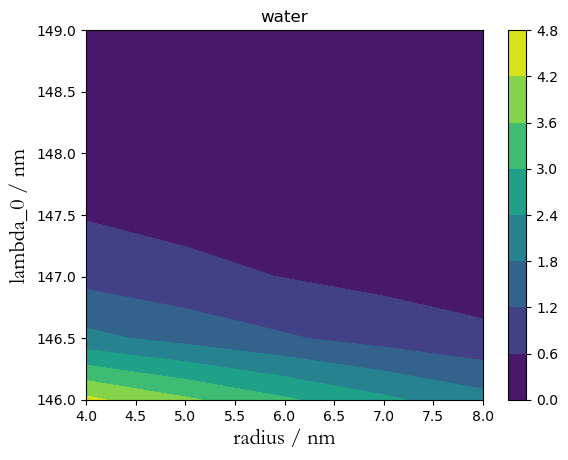

In [18]:
fig, ax = plt.subplots()

c = ax.contourf(r_nm_values, l0_values, chi2_values)

ax.set_xlabel('radius / nm', fontsize=16, fontname='garamond')
ax.set_ylabel('lambda_0 / nm', fontsize=16, fontname='garamond')
ax.set_title(name)

fig.colorbar(c, ax=ax)

plt.show()

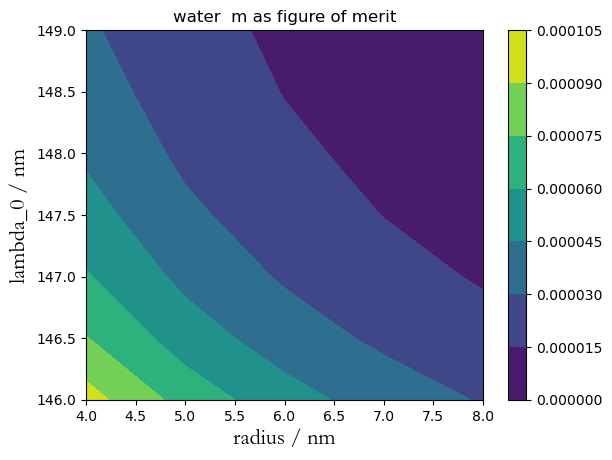

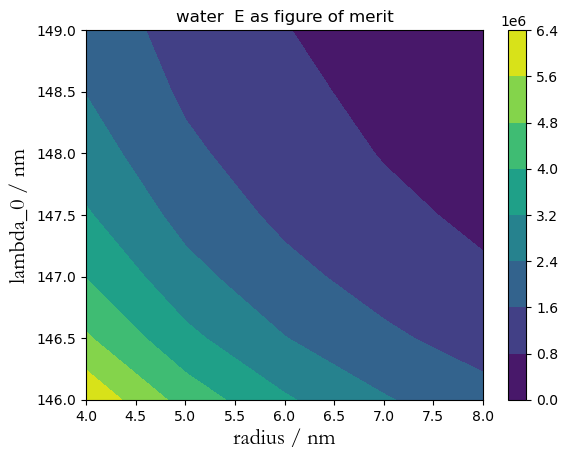

In [19]:
fig, ax = plt.subplots()

c = ax.contourf(r_nm_values, l0_values, figofmerit_values_m)

ax.set_xlabel('radius / nm', fontsize=16, fontname='garamond')
ax.set_ylabel('lambda_0 / nm', fontsize=16, fontname='garamond')
ax.set_title(name  + '  m as figure of merit')

fig.colorbar(c, ax=ax)

plt.show()

array_1d_m = figofmerit_values_m.reshape(-1)
nor_figofmerit_values_m=(figofmerit_values_m/max(array_1d_m))
inv_figofmerit_values_m=1-nor_figofmerit_values_m

fig, ax = plt.subplots()

c = ax.contourf(r_nm_values, l0_values, figofmerit_values_E)

ax.set_xlabel('radius / nm', fontsize=16, fontname='garamond')
ax.set_ylabel('lambda_0 / nm', fontsize=16, fontname='garamond')
ax.set_title(name + '  E as figure of merit')

fig.colorbar(c, ax=ax)

plt.show()

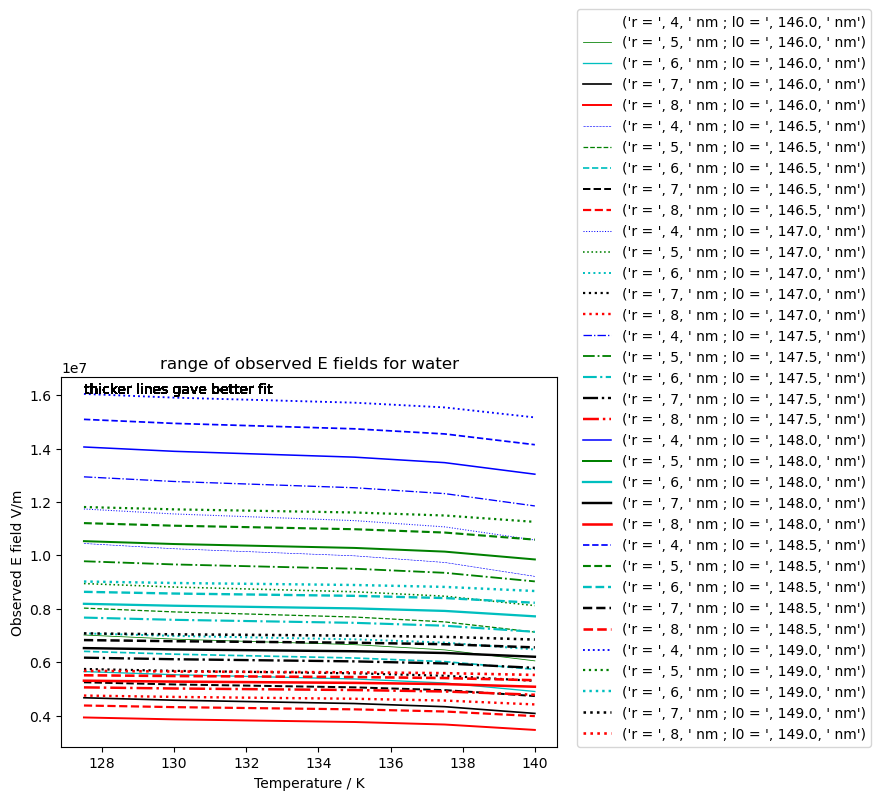

In [20]:

for wavelength_zero in range (r_nm_values_3D.shape[0]):
    colour_list=['b','g','c','k','r','y','m','b','g']
    line_style_list=['-','--',':','-.','-','--',':','-.','-','--']
    for radii in range(r_nm_values_3D.shape[1]):
        text_string = ('r = ', r_nm_values[radii], ' nm ; l0 = ', l0_values[wavelength_zero], ' nm')
        line_style=(colour_list[radii] + line_style_list[wavelength_zero])
        
        plt.plot(Temp, all_obs_E_field[wavelength_zero][radii], line_style, linewidth=2*inv_figofmerit_values_m[wavelength_zero][radii], label=text_string)
        #plt.yscale('log')
        plt.legend(loc=(1.04, 0))
        plt.title('range of observed E fields for '+name)
        plt.xlabel('Temperature / K')
        plt.ylabel('Observed E field V/m')
        plt.text(127.5,max(all_obs_E_field.reshape(-1)),'thicker lines gave better fit',)